# preamble

In [1]:
##%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
#from matplotlib.animation import FuncAnimation
import matplotlib.ticker as mticker
import os
from xmitgcm import open_mdsdataset
from xmitgcm.utils import get_grid_from_input, get_extra_metadata
import xgcm
from scipy.interpolate import interp1d

from myutils import *
from MITgcmutils import llc
import xarray as xr
import cmocean.cm as cmo
#import cartopy.crs as ccrs
import cartopy as cart
# Nils stuff, this is necessary
import matplotlib
import cartopy

## general functions

In [2]:
def sq(a):
    import numpy as np
    a = np.squeeze(a)
    masked_array=np.ma.masked_where(a==0., a)
    return masked_array

def mosaic_llc(field):
    return np.vstack([np.hstack([np.vstack([np.rot90(field[i]) for i in [9,8,7]]),
                                 np.vstack([np.rot90(field[i]) for i in [12,11,10]]),
                                 np.vstack([field[i] for i in [0,1,2]]),
                                 np.vstack([field[i] for i in [3,4,5]])]),
                      np.hstack([np.rot90(field[6])*np.tri(90)[::-1,:],np.triu(np.rot90(field[6],k=2))*np.tri(90)[::-1,:],
                                 np.triu(np.rot90(field[6],k=-1)),np.zeros(field[6].shape)])])[30:315,:]

def llc13to5faces(field):
    """
    fld = llc13to5faces(field) returns a list of 5 faces constructed from 
    the input of a 13-faces field as returned from 
    xmitgcm.open_mdsdataset(...,geometry='llc')
    """
    return [np.vstack((field[0,...],field[1,...],field[2,...])),
            np.vstack((field[3,...],field[4,...],field[5,...])),
            field[6,...],
            np.hstack((field[7,...],field[8,...],field[9,...])),
            np.hstack((field[10,...],field[11,...],field[12,...]))]

def symNorm(vmax):
    import matplotlib.colors as mcolors
    return mcolors.Normalize(vmin=-vmax,vmax=vmax)

face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

def plot2dmap(ax,fld,levs,tstr='dummy',cmap=None):
    
    ax.set_global()
    # for iface in [0,1,2,3,4,5,6,7,8,9,10,11,12]:
    # for iface in [0,1,2,3,4,5,10,11,12]:
    for iface in range(13):
        if iface==12: 
            clrbr=True
            # cbarargs={"orientation": "horizontal"}
            cbarargs={"extend": "both", "orientation": "horizontal"}
            if levs.vmin==0.: 
                cbarargs["extend"] = "max"
        else:
            clrbr=False
            cbarargs=None

        fld.isel(face=iface).plot.pcolormesh(ax=ax, transform=cart.crs.PlateCarree(), x="XC", y="YC", norm=levs,
                                             add_colorbar=clrbr, cmap=cmap, cbar_kwargs=cbarargs)
    
    ax.set_title('%s'%(tstr))
    ax.coastlines()
    ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
    ax.gridlines()
    
def mdsTo13faces(field):
    """fld = llcTo13faces(field) returns an array where axis=-2 has been
    split into 13 to for 13 llc-faces

    """
    nn,nx = field.shape[-2:]
    if nn/nx == 13:
        n = nn//nx//4
        dims = field.shape
        fld13 = field.reshape( ( *dims[:-2], 13, nx, nx ) )
        # move last 3 dimensions to the front for easier manipulation
        fld13 = np.moveaxis(np.moveaxis(
            np.moveaxis(fld13, -1, 0), -1, 0), -1, 0)
        tmp = np.zeros( (6, nx, nx, *dims[:-2]) )
        # re-arrange
        for k in range(n):
            tt = fld13[7:,k::n,:,...].reshape(2*nx,nx,*dims[:-2])
            tmp[  k,...] = tt[:nx,...]
            tmp[3+k,...] = tt[nx:,...]

        fld13[7:,...] = tmp
        # move dimensions back
        fld13 = np.moveaxis(np.moveaxis(
            np.moveaxis(fld13,0,-1),0,-1),0,-1)
    else:
        fld13=np.NaN
        raise ValueError(
            "%s %i,%i with %i/%i = %.1f but not = 13"%(
                "unexpected horizontal llc-dimensions",nn,nx,nn,nx,nn/nx))

    return fld13

def flat2d(x):
    if type(x) is np.ndarray:
        x0 = np.concatenate( [np.concatenate([x[:,0,:,:],x[:,1,:,:],x[:,2,:,:]], axis=-2),
                              np.concatenate([x[:,3,:,:],x[:,4,:,:],x[:,5,:,:]], axis=-2)], axis=-1 )
        y0 = np.concatenate( [np.concatenate([x[:,7,:,:],x[:,8,:,:],x[:,9,:,:]], axis=-1),
                              np.concatenate([x[:,10,:,:],x[:,11,:,:],x[:,12,:,:]], axis=-1)], axis=-2 )
    else:
        x0 = xr.concat( [xr.concat( [x.isel(face=0),x.isel(face=1),x.isel(face=2)], dim = 'j' ),
                         xr.concat( [x.isel(face=3),x.isel(face=4),x.isel(face=5)], dim = 'j' )], dim='i' )
        y0 = xr.concat( [xr.concat( [x.isel(face=7),x.isel(face=8),x.isel(face=9)], dim = 'i' ),
                         xr.concat( [x.isel(face=10),x.isel(face=11),x.isel(face=12)], dim = 'i' )], dim='j' )
    return np.concatenate((x0,np.rot90(y0,k=1,axes=(-2,-1))), axis=-1)

def calc_drake_passage_transport(ds):
    vtrans = (ds.VVEL*ds.hFacS*ds.drF).sum('k')*ds.dxG * 1e-6
    return (vtrans.sel(face=11,i=range(87,90),j_g=62).sum('i') + vtrans.sel(face=12,i=range(20),j_g=62).sum('i'))

def make_masks(coords, withoutArctic=True):
    global_mask = coords.hFacC.isel(k=0)
    # global_mask[6,:,:]=0. # delete Arctic face
    global_mask[2,80:,60:]=0.
    global_mask[7,:,:13]=0.
    global_mask[10,:43,:11]=0.
    # remove Hudson
    global_mask[10,30:54,5:39] = 0.
    global_mask[10,30:62,10:39] = 0.
    #
    atlantic_mask = global_mask.where(coords.YC>-35).where( # Southern Ocean
        np.logical_and(coords.XC<20,coords.XC>-98)).where( # most of the non-Atlantic Ocean
        np.logical_or(coords.XC<0,np.logical_or(coords.YC<30,coords.YC>47))).where(
        np.logical_or(coords.XC<-9,np.logical_or(coords.YC<34,coords.YC>38))).where( # Strait of Gibraltar
        np.logical_or(coords.XC>-70,coords.YC>9)).where( # East Pacific
        np.logical_or(coords.XC>-84,coords.YC>14)).where( # Isthmus of Panama etc.
        np.logical_or(coords.XC>-90,coords.YC>18)).where(
        np.logical_or(coords.XC>-70,coords.YC<50)).fillna(0)
    indopacific_mask = (global_mask-atlantic_mask).where(
        np.logical_and(coords.YC>-35,coords.YC<70)).fillna(0)
    # remove Hudson
    indopacific_mask[10,10:,:39] = 0.
    # remove Med and parts of Arctic
    indopacific_mask[ 2,20:,29:84] = 0.
    # remove Bering strait and Chukchy Sea
    indopacific_mask[ 7,:,:14] = 0.
    if withoutArctic:
        global_mask[6,:,:]=0. # delete Arctic face
        atlantic_mask[6,:,:]=0. # delete Arctic face
        indopacific_mask[6,:,:]=0. # delete Arctic face
    return global_mask, atlantic_mask, indopacific_mask

def zonal_mean(ds,fld,msk):
    # mask the Med
    dvol = flat2d(ds.hFacC*ds.rA*ds.drF*msk)
    # mask the Med
    dvol[:,200:217,33:80]=0
    dvol[:,217:222,40:60]=0
    ra = dvol.sum(axis=-1)
    ra[ra==0]=np.Inf
    fldz = (flat2d(fld)*dvol).sum(axis=-1)/ra
    return np.ma.masked_array(fldz,fldz==0)

def zonal_sum(fld):
    # zonal integral of scalar field
    return flat2d(fld).sum(axis=-1)

def zonal_lat_bin(clat,res=1.):
    lat_group = np.round(clat/res)*res
    latg = np.unique(lat_group.values.ravel())
    return latg - 0.5*res
    
def zonal_sum_bin(data,clat,res=1.):
    lat_group = np.round(clat/res)*res
    return data.where(data>0.).groupby(lat_group).sum()
    
def calc_flux_divergence(dl):
    # this is done separately
    # grd = xgcm.Grid(dl, periodic=False, face_connections=face_connections)
    # layer flux in two directions
    flxx = dl.LaUH1RHO*dl.dyG
    flxy = dl.LaVH1RHO*dl.dxG
    # difference in the x and y directions
    diff_flx = grd.diff_2d_vector({'X': flxx, 'Y': flxy}, boundary='fill')
    # divergence
    return diff_flx['X'] + diff_flx['Y']

def calc_wflux_dia(dl):
    flx_div = calc_flux_divergence(dl)
    # compute wflux at w-points (above c-points) by reversing the k-axis,
    # integrating (now from the bottom up) cumulatively,
    # assuming wflx=0 at n+1
    wflux = -flx_div.reindex(l1_c=flx_div.l1_c[::-1]).cumsum(dim='l1_c')
    # and reverse the k-axis again
    return wflux.reindex(l1_c=wflux.l1_c[::-1])

## MOC functions

In [3]:
import warnings
def compute_moc_layers(dl,msk):
    wflux = calc_wflux_dia(dl)
    return compute_moc(wflux*msk)

def compute_moc(wflux):
    # zonal integral
    wflx = zonal_sum(wflux)
    # order of integration: from north to south because of Atlantic MOC, requires sign change
    mocstrf = -np.flip(np.flip(wflx,axis=-1).cumsum(axis=-1),axis=-1)
    mocstrf[wflx==0]=0.
    return mocstrf

# def compute_layers(dl,msk):
#     grd = xgcm.Grid(dl, periodic=False, face_connections=face_connections)
#     lahc = grd.interp_2d_vector({'X': dl.LaHw1RHO, 
#                                  'Y': dl.LaHs1RHO},
#                                  to = 'center', boundary='fill')
#     lath = 0.5*(lahc['X']+lahc['Y'])*msk
#     zz = flat2d(lath).cumsum(axis=0)
#     return zz.mean(axis=-1,where=zz!=0)
def compute_layers(dl,msk):
    grd = xgcm.Grid(dl, periodic=False, face_connections=face_connections)
    lahc = grd.interp_2d_vector({'X': dl.LaHw1RHO, 
                                 'Y': dl.LaHs1RHO},
                                 to = 'center', boundary='fill')
    lath = 0.5*(lahc['X']+lahc['Y'])*msk
    # not sure if this is better or worse, but does not make much of a difference
    #lath = np.maximum(lahc['X'],lahc['Y'])*msk
    zzz = flat2d(lath)
    # first do the zonal average
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        zz = zzz.mean(axis=-1,where=zzz!=0)
    zz[np.isnan(zz)]=0 # need to get rid of NaNs etc.
    # then do the vertical integral
    z = zz.cumsum(axis=0)
    #z[zz==0]=0 # this does not work
    # The top level coordinate should always be zero (surface),
    # but with the cumulative sum, the first value of z is the 
    # depth of the first interface; here push down all values to k+1
    z = np.roll(z,1,axis=0)
    # and make sure that the surface layer is zero
    z[0,:]=0
      
    return z


# Nils multiple extra functions for plotting

In [4]:
import matplotlib
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.path as mpath

def arrange_axes(nx,ny,
                 sharex = True,
                 sharey = False,
                 xlabel = '',
                 ylabel = '',
                 # labeling axes with e.g. (a), (b), (c)
                 do_axes_labels = True,
                 axlab_kw = dict(),
                 # colorbar
                 plot_cb = True,
                 # projection (e.g. for cartopy)
                 projection = None,
                 # aspect ratio of axes
                 asp = 1.,
                 sasp = 0.,  # for compability with older version of arrange_axes
                 # width and height of axes
                 wax = 'auto',
                 hax = 4.,
                 # extra figure spaces (left, right, top, bottom)
                 dfigl = 0.0,
                 dfigr = 0.0,
                 dfigt = 0.0,
                 dfigb = 0.0,
                 # space aroung axes (left, right, top, bottom) 
                 daxl = 1.8, # reset to zero if sharex==False
                 daxr = 0.8,
                 daxt = 0.8,
                 daxb = 1.2, # reset to zero if sharex==True
                 # space around colorbars (left, right, top, bottom) 
                 dcbl = -0.5,
                 dcbr = 1.4,
                 dcbt = 0.0,
                 dcbb = 0.5,
                 # width and height of colorbars
                 wcb = 0.5,
                 hcb = 'auto',
                 # factors to increase widths and heights of axes and colorbars
                 fig_size_fac = 1.,
                 f_wax = 1.,
                 f_hax = 1.,
                 f_wcb = 1.,
                 f_hcb = 1.,
                 # factors to increase spaces (figure)
                 f_dfigl = 1.,
                 f_dfigr = 1.,
                 f_dfigt = 1.,
                 f_dfigb = 1.,
                 # factors to increase spaces (axes)
                 f_daxl = 1.,
                 f_daxr = 1.,
                 f_daxt = 1.,
                 f_daxb = 1.,
                 # factors to increase spaces (colorbars)
                 f_dcbl = 1.,
                 f_dcbr = 1.,
                 f_dcbt = 1.,
                 f_dcbb = 1.,
                 # font sizes of labels, titles, ticks
                 fs_label = 10.,
                 fs_title = 12.,
                 fs_ticks = 10.,
                 # font size increasing factor
                 f_fs = 1,
                 reverse_order = False,
                ):

  # factor to convert cm into inch
  cm2inch = 0.3937

  if sasp!=0:
    print('::: Warning: You are using keyword ``sasp`` for setting the aspect ratio but you should switch to use ``asp`` instead.:::')
    asp = 1.*sasp

  # --- set hcb in case it is auto
  if isinstance(wax, str) and wax=='auto':
    wax = hax/asp

  # --- set hcb in case it is auto
  if isinstance(hcb, str) and hcb=='auto':
    hcb = hax

  # --- rename horizontal->bottom and vertical->right
  if isinstance(plot_cb, str) and plot_cb=='horizontal':
    plot_cb = 'bottom'
  if isinstance(plot_cb, str) and plot_cb=='vertical':
    plot_cb = 'right'
  
  # --- apply fig_size_fac
  # font sizes
  #f_fs *= fig_size_fac
  # factors to increase widths and heights of axes and colorbars
  f_wax *= fig_size_fac
  f_hax *= fig_size_fac
  #f_wcb *= fig_size_fac
  f_hcb *= fig_size_fac
  ## factors to increase spaces (figure)
  #f_dfigl *= fig_size_fac
  #f_dfigr *= fig_size_fac
  #f_dfigt *= fig_size_fac
  #f_dfigb *= fig_size_fac
  ## factors to increase spaces (axes)
  #f_daxl *= fig_size_fac
  #f_daxr *= fig_size_fac
  #f_daxt *= fig_size_fac
  #f_daxb *= fig_size_fac
  ## factors to increase spaces (colorbars)
  #f_dcbl *= fig_size_fac
  #f_dcbr *= fig_size_fac
  #f_dcbt *= fig_size_fac
  #f_dcbb *= fig_size_fac
  
  # --- apply font size factor
  fs_label *= f_fs
  fs_title *= f_fs
  fs_ticks *= f_fs

  # make vector of plot_cb if it has been true or false before
  # plot_cb can have values [{1}, 0] 
  # with meanings:
  #   1: plot cb; 
  #   0: do not plot cb
  plot_cb_right  = False
  plot_cb_bottom = False
  if isinstance(plot_cb, bool) and (plot_cb==True):
    plot_cb = np.ones((nx,ny))  
  elif isinstance(plot_cb, bool) and (plot_cb==False):
    plot_cb = np.zeros((nx,ny))
  elif isinstance(plot_cb, str) and plot_cb=='right':
    plot_cb = np.zeros((nx,ny))
    plot_cb_right = True
  elif isinstance(plot_cb, str) and plot_cb=='bottom':
    plot_cb = np.zeros((nx,ny))
    plot_cb_bottom = True
  else:
    plot_cb = np.array(plot_cb)
    if plot_cb.size!=nx*ny:
      raise ValueError('Vector plot_cb has wrong length!')
    if plot_cb.shape[0]==nx*ny:
      plot_cb = plot_cb.reshape(ny,nx).transpose()
    elif plot_cb.shape[0]==ny:
      plot_cb = plot_cb.transpose()
  
  # --- make list of projections if it is not a list
  if not isinstance(projection, list):
    projection = [projection]*nx*ny
  
  # --- make arrays and multiply by f_*
  daxl = np.array([daxl]*nx)*f_daxl
  daxr = np.array([daxr]*nx)*f_daxr
  dcbl = np.array([dcbl]*nx)*f_dcbl
  dcbr = np.array([dcbr]*nx)*f_dcbr
  
  wax = np.array([wax]*nx)*f_wax
  wcb = np.array([wcb]*nx)*f_wcb
  
  daxt = np.array([daxt]*ny)*f_daxt
  daxb = np.array([daxb]*ny)*f_daxb
  dcbt = np.array([dcbt]*ny)*f_dcbt
  dcbb = np.array([dcbb]*ny)*f_dcbb
  
  hax = np.array([hax]*ny)*f_hax
  hcb = np.array([hcb]*ny)*f_hcb
  
  # --- adjust for shared axes
  if sharex:
    daxb[:-1] = 0.
  
  if sharey:
    daxl[1:] = 0.

  # --- adjust for one colorbar at the right or bottom
  if plot_cb_right:
    daxr_s = daxr[0]
    dcbl_s = dcbl[0]
    dcbr_s = dcbr[0]
    wcb_s  = wcb[0]
    hcb_s  = hcb[0]
    dfigr += dcbl_s+wcb_s+0.*dcbr_s+daxl[0]
  if plot_cb_bottom:
    hcb_s  = wcb[0]
    wcb_s  = wax[0]
    dcbb_s = dcbb[0]+daxb[-1]
    dcbt_s = dcbt[0]
    #hcb_s  = hcb[0]
    dfigb += dcbb_s+hcb_s+dcbt_s
  
  # --- adjust for columns without colorbar
  delete_cb_space = plot_cb.sum(axis=1)==0
  dcbl[delete_cb_space] = 0.0
  dcbr[delete_cb_space] = 0.0
  wcb[delete_cb_space]  = 0.0
  
  # --- determine ax position and fig dimensions
  x0 =   dfigl
  y0 = -(dfigt)
  
  pos_axcm = np.zeros((nx*ny,4))
  pos_cbcm = np.zeros((nx*ny,4))
  nn = -1
  y00 = y0
  x00 = x0
  for jj in range(ny):
    y0   += -(daxt[jj]+hax[jj])
    x0 = x00
    for ii in range(nx):
      nn += 1
      x0   += daxl[ii]
      pos_axcm[nn,:] = [x0, y0, wax[ii], hax[jj]]
      pos_cbcm[nn,:] = [x0+wax[ii]+daxr[ii]+dcbl[ii], y0, wcb[ii], hcb[jj]]
      x0   += wax[ii]+daxr[ii]+dcbl[ii]+wcb[ii]+dcbr[ii]
    y0   += -(daxb[jj])
  wfig = x0+dfigr
  hfig = y0-dfigb
  
  # --- transform from negative y axis to positive y axis
  hfig = -hfig
  pos_axcm[:,1] += hfig
  pos_cbcm[:,1] += hfig
  
  # --- convert to fig coords
  cm2fig_x = 1./wfig
  cm2fig_y = 1./hfig
  
  pos_ax = 1.*pos_axcm
  pos_cb = 1.*pos_cbcm
  
  pos_ax[:,0] = pos_axcm[:,0]*cm2fig_x
  pos_ax[:,2] = pos_axcm[:,2]*cm2fig_x
  pos_ax[:,1] = pos_axcm[:,1]*cm2fig_y
  pos_ax[:,3] = pos_axcm[:,3]*cm2fig_y
  
  pos_cb[:,0] = pos_cbcm[:,0]*cm2fig_x
  pos_cb[:,2] = pos_cbcm[:,2]*cm2fig_x
  pos_cb[:,1] = pos_cbcm[:,1]*cm2fig_y
  pos_cb[:,3] = pos_cbcm[:,3]*cm2fig_y

  # --- find axes center (!= figure center)
  x_ax_cent = pos_axcm[0,0] +0.5*(pos_axcm[-1,0]+pos_axcm[-1,2]-pos_axcm[0,0])
  y_ax_cent = pos_axcm[-1,1]+0.5*(pos_axcm[0,1] +pos_axcm[0,3] -pos_axcm[-1,1])
  
  # --- make figure and axes
  fig = plt.figure(figsize=(wfig*cm2inch, hfig*cm2inch))
  
  hca = [0]*(nx*ny)
  hcb = [0]*(nx*ny)
  nn = -1
  for jj in range(ny):
    for ii in range(nx):
      nn+=1
  
      # --- axes
      hca[nn] = fig.add_subplot(position=pos_ax[nn,:], projection=projection[nn])
      hca[nn].set_position(pos_ax[nn,:])
  
      # --- colorbar
      if plot_cb[ii,jj] == 1:
        hcb[nn] = fig.add_subplot(position=pos_cb[nn,:])
        hcb[nn].set_position(pos_cb[nn,:])
      ax  = hca[nn]
      cax = hcb[nn] 
  
      # --- label
      ax.set_xlabel(xlabel, fontsize=fs_label)
      ax.set_ylabel(ylabel, fontsize=fs_label)
      #ax.set_title('', fontsize=fs_title)
      matplotlib.rcParams['axes.titlesize'] = fs_title
      ax.tick_params(labelsize=fs_ticks)
      if plot_cb[ii,jj] == 1:
        hcb[nn].tick_params(labelsize=fs_ticks)
  
      #ax.tick_params(pad=-10.0)
      #ax.xaxis.labelpad = 0
      #ax._set_title_offset_trans(float(-20))
  
      # --- axes ticks
      # delete labels for shared axes
      if sharex and jj!=ny-1:
        hca[nn].ticklabel_format(axis='x',style='plain',useOffset=False)
        hca[nn].tick_params(labelbottom=False)
        hca[nn].set_xlabel('')
  
      if sharey and ii!=0:
        hca[nn].ticklabel_format(axis='y',style='plain',useOffset=False)
        hca[nn].tick_params(labelleft=False)
        hca[nn].set_ylabel('')
  
      # ticks for colorbar 
      if plot_cb[ii,jj] == 1:
        hcb[nn].set_xticks([])
        hcb[nn].yaxis.tick_right()
        hcb[nn].yaxis.set_label_position("right")

  #--- needs to converted to fig coords (not cm)
  if plot_cb_right:
    nn = -1
    #pos_cb = np.array([(wfig-(dfigr+dcbr_s+wcb_s))*cm2fig_x, (y_ax_cent-0.5*hcb_s)*cm2fig_y, wcb_s*cm2fig_x, hcb_s*cm2fig_y])
    pos_cb = np.array([ (pos_axcm[-1,0]+pos_axcm[-1,2]+daxr_s+dcbl_s)*cm2fig_x, 
                        (y_ax_cent-0.5*hcb_s)*cm2fig_y, 
                        (wcb_s)*cm2fig_x, 
                        (hcb_s)*cm2fig_y 
                      ])
    hcb[nn] = fig.add_subplot(position=pos_cb)
    hcb[nn].tick_params(labelsize=fs_ticks)
    hcb[nn].set_position(pos_cb)
    hcb[nn].set_xticks([])
    hcb[nn].yaxis.tick_right()
    hcb[nn].yaxis.set_label_position("right")

  if plot_cb_bottom:
    nn = -1
    pos_cb = np.array([ (x_ax_cent-0.5*wcb_s)*cm2fig_x, 
                        (dcbb_s)*cm2fig_y, 
                        (wcb_s)*cm2fig_x, 
                        (hcb_s)*cm2fig_y
                      ])
    hcb[nn] = fig.add_subplot(position=pos_cb)
    hcb[nn].set_position(pos_cb)
    hcb[nn].tick_params(labelsize=fs_ticks)
    hcb[nn].set_yticks([])

  if reverse_order:
    isort = np.arange(nx*ny, dtype=int).reshape((ny,nx)).transpose().flatten()
    hca = list(np.array(hca)[isort]) 
    hcb = list(np.array(hcb)[isort])

  # add letters for subplots
  if (do_axes_labels) and (axlab_kw is not None):
    hca = axlab(hca, fontdict=axlab_kw)

  return hca, hcb

# ================================================================================ 
def axlab(hca, figstr=[], posx=[-0.00], posy=[1.05], fontdict=None):
  """
input:
----------
  hca:      list with axes handles
  figstr:   list with strings that label the subplots
  posx:     list with length 1 or len(hca) that gives the x-coordinate in ax-space
  posy:     list with length 1 or len(hca) that gives the y-coordinate in ax-space
last change:
----------
2015-07-21
  """

  # make list that looks like [ '(a)', '(b)', '(c)', ... ]
  if len(figstr)==0:
    #lett = "abcdefghijklmnopqrstuvwxyz"
    lett  = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"]
    lett += ["a2","b2","c2","d2","e2","f2","g2","h2","i2","j2","k2","l2","m2","n2","o2","p2","q2","r2","s2","t2","u2","v2","w2","x2","y2","z2"]
    lett = lett[0:len(hca)]
    figstr = ["z"]*len(hca)
    for nn, ax in enumerate(hca):
      figstr[nn] = "(%s)" % (lett[nn])
  
  if len(posx)==1:
    posx = posx*len(hca)
  if len(posy)==1:
    posy = posy*len(hca)
  
  # draw text
  for nn, ax in enumerate(hca):
    ht = hca[nn].text(posx[nn], posy[nn], figstr[nn], 
                      transform = hca[nn].transAxes, 
                      horizontalalignment = 'right',
                      fontdict=fontdict)
    # add text handle to axes to give possibility of changing text properties later
    # e.g. by hca[nn].axlab.set_fontsize(8)
    hca[nn].axlab = ht
#  for nn, ax in enumerate(hca):
#    #ax.set_title(figstr[nn]+'\n', loc='left', fontsize=10)
#    ax.set_title(figstr[nn], loc='left', fontsize=10)
  return hca

def shade(
              x='auto', y='auto', datai='auto',
              ax='auto', cax=0,
              cmap='auto',
              cincr=-1.,
              norm=None,
              rasterized=True,
              clim=[None, None],
              extend='both',
              clevs=None,
              contfs=None,
              conts=None,
              nclev='auto',
              #cint='auto', # old: use cincr now
              contcolor='k',
              contthick=0.,
              contlw=1.,
              use_pcol=True,
              use_pcol_or_contf=True,
              cbticks='auto',
              cbtitle='',
              cbdrawedges='auto',
              #cborientation='vertical',
              cborientation='auto',
              cbkwargs=None,
              adjust_axlims=True,
              bmp=None,
              transform=None,
              projection=None,
              logplot=False,
              edgecolor='none',
           ):
    """ Convenient wrapper around pcolormesh, contourf, contour and their triangular versions.
    """
    # --- decide whether regular or triangular plots should be made
    if isinstance(datai, str) and datai=='auto':
      Tri = x
      datai = y
      rectangular_grid = False
    else:
      rectangular_grid = True

    if projection is not None:
      transform = projection


    # --- decide whether pcolormesh or contourf plot
    if use_pcol_or_contf:
      if contfs is None:
        use_pcol = True
        use_contf = False
      else:
        use_pcol = False
        use_contf = True
    else:
        use_pcol = False
        use_contf = False
    #if use_pcol and use_contf:
    #  raise ValueError('::: Error: Only one of use_pcol or use_contf can be True. :::')

    # --- mask 0 and negative values in case of log plot
    #data = 1.*datai
    data = datai.copy()
    if logplot and isinstance(data, np.ma.MaskedArray):
      data[data<=0.0] = np.ma.masked
      data = np.ma.log10(data) 
    elif logplot and not isinstance(data, np.ma.MaskedArray):
      data[data<=0.0] = np.nan
      data = np.log10(data) 
  
    # --- clim
    if isinstance(clim, str) and clim=='auto':
      clim = [None, None]
    elif isinstance(clim, str) and clim=='sym':
      clim = np.abs(data).max()
    clim=np.array(clim)
    if clim.size==1:
      clim = np.array([-1, 1])*clim
    if clim[0] is None:
      clim[0] = data.min()
    if clim[1] is None:
      clim[1] = data.max()
  
    # --- cmap
    if (clim[0]==-clim[1]) and cmap=='auto':
      cmap = 'RdBu_r'
    elif cmap=='auto':
      #cmap = 'viridis'
      cmap = 'RdYlBu_r'
    if isinstance(cmap, str):
      cmap = getattr(plt.cm, cmap)
  
    if use_pcol:
      # --- norm
      if cincr>0.:
        clevs = np.arange(clim[0], clim[1]+cincr, cincr)
        use_norm = True
      elif use_pcol and clevs is not None:
        clevs = np.array(clevs)
        use_norm = True
      elif norm is not None:
        use_norm = False # prevent that norm is overwritten later on
      else:
        norm = None
        use_norm = False
    elif use_contf:
      contfs = calc_conts(contfs, clim, cincr, nclev)
      clevs = contfs
      use_norm = True
    else:
      use_norm = False

    if use_norm:
      #norm = matplotlib.colors.BoundaryNorm(boundaries=clevs, ncolors=cmap.N)
      nlev = clevs.size
      # --- expanded norm and cmap
      norm_e = matplotlib.colors.BoundaryNorm(boundaries=np.arange(0,nlev+2,1), ncolors=cmap.N)
      cmap_e = matplotlib.colors.ListedColormap(cmap(norm_e(np.arange(0,nlev+1,1))))
      # --- actuall cmap with over and under values
      cmap = matplotlib.colors.ListedColormap(cmap(norm_e(np.arange(1,nlev,1))))        
      norm = matplotlib.colors.BoundaryNorm(boundaries=clevs, ncolors=cmap.N)
      cmap.set_under(cmap_e(norm_e(0)))
      cmap.set_over(cmap_e(norm_e(nlev)))
      vmin = None
      vmax = None
    elif norm:
      vmin = None
      vmax = None
      clim = [None, None]
    else:
      vmin = clim[0]
      vmax = clim[1]
  
    # --- decide whether to use extra contour lines
    if conts is None:
      use_cont = False
    else:
      use_cont = True
      conts = calc_conts(conts, clim, cincr, nclev)
    if use_norm:
      clim = [None, None]
  
    # --- decide whether there should be black edges at colorbar
    if isinstance(cbdrawedges, str) and cbdrawedges=='auto':
      if use_norm or use_contf:
        cbdrawedges = True
      else:
        cbdrawedges = False
    else:
      cbdrawedges = False
  
    # --- necessary cartopy settings
    ccrsdict = dict()
    if transform is not None:
      ccrsdict = dict(transform=transform)
      #adjust_axlims = False
      #adjust_axlims = True
    
    # --- make axes if necessary
    if ax == 'auto':
      ax = plt.gca()
  
    if rectangular_grid:
      # --- adjust x and y if necessary
      # ------ make x and y 2D
      if x.ndim==1:
        x, y = np.meshgrid(x, y)
  
      # ------ convert to Basemap maps coordinates
      if bmp is not None:
        x, y = bmp(x, y)
        
      # ------ bring x and y to correct shape for contour
      if (use_cont) or (use_contf):
        if x.shape[1] != data.shape[1]:
          xc = 0.25*(x[1:,1:]+x[:-1,1:]+x[1:,:-1]+x[:-1,:-1])
          yc = 0.25*(y[1:,1:]+y[:-1,1:]+y[1:,:-1]+y[:-1,:-1])
        else:
          xc = x.copy()
          yc = y.copy()
      
    # --- allocate list of all plot handles
    hs = []
  
    # --- color plot
    # either pcolormesh plot
    if use_pcol:
      if rectangular_grid:
        hm = ax.pcolormesh(x, y, 
                           data, 
                           vmin=clim[0], vmax=clim[1],
                           cmap=cmap, 
                           norm=norm,
                           rasterized=rasterized,
                           edgecolor=edgecolor,
                           shading='auto',
                           **ccrsdict
                          )
      else:
        hm = ax.tripcolor(Tri, 
                          data, 
                          vmin=clim[0], vmax=clim[1],
                          cmap=cmap, 
                          norm=norm,
                          rasterized=rasterized,
                          edgecolor=edgecolor,
                          **ccrsdict
                         )
      hs.append(hm)
    # or contourf plot
    elif use_contf:
      if rectangular_grid:
        hm = ax.contourf(xc, yc, 
                         data, contfs,
                         vmin=clim[0], vmax=clim[1],
                         cmap=cmap, 
                         norm=norm,
                         extend=extend,
                         **ccrsdict
                        )
      else:
        raise ValueError("::: Error: Triangular contourf not supported yet. :::")
        # !!! This does not work sinc Tri.x.size!=data.size which is natural for the picon Triangulation. Not sure why matplotlib tries to enforce this.
        #hm = ax.tricontourf(Tri,
        #                 data, contfs,
        #                 vmin=clim[0], vmax=clim[1],
        #                 cmap=cmap, 
        #                 norm=norm,
        #                 extend=extend,
        #                 **ccrsdict
        #                   )
      hs.append(hm)
  
      # this prevents white lines if fig is saved as pdf
      for cl in hm.collections: 
        cl.set_edgecolor("face")
        cl.set_rasterized(True)
      # rasterize
      if rasterized:
        zorder = -5
        ax.set_rasterization_zorder(zorder)
        for cl in hm.collections:
# This line causes problems with cartopy and contourfs. The plot seems to be unvisible.
#          cl.set_zorder(zorder - 1)
          cl.set_rasterized(True)
    else:
      hm = None
  
    # --- contour plot (can be in addition to color plot above)
    if use_cont:
      if rectangular_grid:
        hc = ax.contour(xc, yc, data, conts, 
                        colors=contcolor, linewidths=contlw, **ccrsdict)
      else:
        raise ValueError("::: Error: Triangular contour not supported yet. :::")
      # ------ if there is a contour matching contthick it will be made thicker
      try:
        i0 = np.where(hc.levels==contthick)[0][0]
        hc.collections[i0].set_linewidth(2.5*contlw)
      except:
        pass
      hs.append(hc)
  
    # --- colorbar
    if (cax!=0) and (hm is not None): 
      # ------ axes for colorbar needs to be created
      if cax == 1:
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        div = make_axes_locatable(ax)
        cax = div.append_axes("right", size="10%", pad=0.1)
      # ------ determine cborientation
      if cborientation=='auto':
        if cax.get_xticks().size==0:
          cborientation = 'vertical'
        else:
          cborientation = 'horizontal'
      if not cbkwargs:
        cbkwargs = dict(orientation=cborientation, extend='both')
      # ------ make actual colorbar
      #cb = plt.colorbar(mappable=hm, cax=cax, orientation=cborientation, extend='both')
      cb = plt.colorbar(mappable=hm, cax=cax, **cbkwargs)
      # ------ prevent white lines if fig is saved as pdf
      cb.solids.set_edgecolor("face")
      # ------ use exponential notation for large colorbar ticks
      try:
        cb.formatter.set_powerlimits((-3, 3))
      except:
        pass
      # ------ colorbar ticks
      if isinstance(cbticks, np.ndarray) or isinstance(cbticks, list):
        cb.set_ticks(cbticks)
      else:
        if use_norm:
          dcl = np.diff(clevs)
          if (np.isclose(dcl, dcl[0])).all(): 
            cb.set_ticks(clevs[::2])
          else:
            cb.set_ticks(clevs)
        elif use_norm==False and norm is not None:
          pass
        else:
          cb.locator = ticker.MaxNLocator(nbins=5)
      cb.update_ticks()
      # ------ colorbar title
      cax.set_title(cbtitle)
      # ------ add cb to list of handles
      hs.append(cb)
  
    # --- axes labels and ticks
    if adjust_axlims:
      ax.locator_params(nbins=5)
      if rectangular_grid: 
        ax.set_xlim(x.min(), x.max())
        ax.set_ylim(y.min(), y.max())
      else:
        ax.set_xlim(Tri.x.min(), Tri.x.max())
        ax.set_ylim(Tri.y.min(), Tri.y.max())
    return hs 

def calc_conts(conts, clim, cincr, nclev):
  # ------ decide how to determine contour levels
  if isinstance(conts, np.ndarray) or isinstance(conts, list):
    # use given contours 
    conts = np.array(conts)
  else:
    # calculate contours
    # ------ decide whether contours should be calculated by cincr or nclev
    if cincr>0:
      conts = np.arange(clim[0], clim[1]+cincr, cincr)
    else:
      if isinstance(nclev,str) and nclev=='auto':
        nclev = 11
      conts = np.linspace(clim[0], clim[1], nclev)
  return conts

def plot_settings(ax, xlim=None, ylim=None, xticks=None, yticks=None, xlocs=None, ylocs=None,
                     ticks_position='both', template=None,
                     x_minor_tick_diff='auto', y_minor_tick_diff='auto',
                     # cartopy specific settings
                     projection=None,  # not necessary
                     draw_labels=False,
                     do_xylim=True,
                     do_xyticks=True,
                     do_xyminorticks=True,
                     do_gridlines=True,
                     coastlines_color='k', coastlines_resolution='110m',
                     land_zorder=2, land_facecolor='0.5'):
    # --- templates
    if template=='global':
        xlim = [-180,180]
        ylim = [-90,90]
        xticks = np.arange(-120,121,60.)
        yticks = np.arange(-60,61,30.)
        xlocs = np.arange(-180,181,60.)
        ylocs = np.arange(-90,91,30.)
        x_minor_tick_diff = 20.
        y_minor_tick_diff = 10.
    if template=='np':
        xlim = [-180,180]
        ylim = [45,90]
        xticks = np.arange(-180,181,45.)
        yticks = np.arange(45,91,5.)
        xlocs = xticks
        ylocs = yticks
    if template=='sp':
        xlim = [-180,180]
        ylim = [-90,-50]
        xticks = np.arange(-180,181,45.)
        yticks = np.arange(-90, -49, 5.)
        xlocs = xticks
        ylocs = yticks
    elif template=='na':
        xlim = [-80,0]
        ylim = [30,70]
    elif template=='section':
        ax.set_facecolor(land_facecolor)
        if yticks is None:
            yticks = np.arange(1000,6100,1000)
        if ylim is None:
            ylim = [6000,0]
        if xticks is None:
            xticks = np.arange(-75,90,25)
        if xlim is None:
            xlim = [-80,90]

    # --- decide whether to use cartopy
    if False: #isinstance(ax, cartopy.mpl.geoaxes.GeoAxesSubplot):
        use_cartopy = True
        projection = ax.projection
    else:
        use_cartopy = False
        projection = None

    if use_cartopy:
        # gl = ax.gridlines(draw_labels=["left", "bottom"], xlocs=xlocs, ylocs=ylocs)
        # gl.xlocator = mticker.FixedLocator(xlocs)
        # gl.ylocator = mticker.FixedLocator(ylocs)
        # gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
        # gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER
        gl = ax.gridlines(draw_labels=draw_labels, xlocs=xlocs, ylocs=ylocs)
        gl.top_labels = False
        gl.right_labels = False
        #for tick in ax.xaxis.get_ticklabels()+ax.yaxis.get_ticklabels():
        #  tick.set_fontsize(8)
        if isinstance(land_facecolor, str) and land_facecolor!='none':
            feature = cartopy.feature.LAND
            #feature = feature.with_scale(coastlines_resolution)
            ax.add_feature(feature, zorder=land_zorder, facecolor=land_facecolor)
        if coastlines_color is not None:
            #ax.coastlines(color=coastlines_color, resolution=coastlines_resolution)
            feature = cartopy.feature.COASTLINE
            #feature = feature.with_scale(coastlines_resolution)
            ax.add_feature(feature, zorder=land_zorder, edgecolor=coastlines_color)
        ax.set_extent([xlim[0],xlim[1],ylim[0],ylim[1]], crs=ccrs.PlateCarree())
        if template=='np' or template=='sp':
            theta = np.linspace(0, 2*np.pi, 100)
            center, radius = [0.5, 0.5], 0.5
            verts = np.vstack([np.sin(theta), np.cos(theta)]).T
            circle = mpath.Path(verts * radius + center)
            ax.set_boundary(circle, transform=ax.transAxes)
    else:
        if do_gridlines:
            ax.grid(True)
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        ax.set_xlim(xlim)
        ax.set_ylim([6000,0])
    return

def fmt_cbticks_reduced(x, pos):
    a, b = f'{x:.2e}'.split('e')
    b = int(b)
    levs = r'$10^{{{}}}$'.format(b)
    # print(a, b, levs)
    if a=="1.00":
        return levs
    elif a=="-1.00":
        return '-'+levs

def fmt_cbticks_full(x, pos):
    a, b = f'{x:.2e}'.split('e')
    b = int(b)
    levs = r'${} \times 10^{{{}}}$'.format(a, b)
    # print(a, b, levs)
    return levs

def fmt_cbticks_simple(x, pos):
    return f'{x:.2e}'

# def get_log_clevs(clim, dosym=False, numspaces=5):
#     clim = np.sort(np.array(clim, dtype=float))
#     conts = np.power(10, np.arange(clim[0], clim[1]+1./numspaces,1./numspaces))
#     linthresh = conts.min()
#     if dosym:
#         conts = np.concatenate((-conts[::-1], [0.], conts))
#     if not dosym:
#         norm = mcolors.LogNorm(vmin=10**clim[0], vmax=10**clim[1])
#     else:
#         norm = mcolors.SymLogNorm(linthresh=linthresh, linscale=1.,
#                           vmin=clim[0], vmax=clim[1], base=10)
#     return clim, norm, conts
def get_log_clevs(clim, dosym=False, numspaces=5):
    clim = np.sort(np.array(clim, dtype=float))
    conts = np.power(10, np.arange(clim[0], clim[1]+1./numspaces,1./numspaces))
    linthresh = conts.min()
    if dosym:
        conts = np.concatenate((-conts[::-1], [0.], conts))
    if not dosym:
        norm = mcolors.LogNorm(vmin=conts[0], vmax=conts[-1])
    else:
        norm = mcolors.SymLogNorm(linthresh=linthresh, linscale=linthresh,
                          vmin=conts[0], vmax=conts[-1], base=10)
    return clim, norm, conts 

# Paths and names

In [5]:
deltat=3600.
ny, nx = 1170, 90
# prefix=['diagsKrN2']

landcolor = '0.7'
landcolor = '0.5'

#
r0,r1,r2,r3='run16','run27','run24','run23'
bdir='/albedo/work/projects/p_idemix_tr181/llc90'
gdir='/albedo/work/projects/p_idemix_tr181/llc90/grid'
fdir='/albedo/home/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs'
rdir0=os.path.join(bdir,r0)
rdir1=os.path.join(bdir,r1)
rdir2=os.path.join(bdir,r2)
rdir3=os.path.join(bdir,r3)

postprocdir = os.path.join(bdir,'postprocessing')

rname0='CTRL'
rname1='CTRL'
rname2='CTRL'
rname3='CTRL'

rnames = [rname0,rname1,rname2,rname3]
rs = [r0,r1,r2,r3]
#rnames= [rname0,rname1,rname2]
#rnames= [rname2]
rdirs = []
for r in rs:
    rdirs.append(os.path.join(bdir,'%s_CTRL'%(r)))

# find out the file numbers to read
cycle = 5
startyear = 1958
refdate = "%i-1-1 0:0:0"%(startyear-(cycle-1)*62)
mycycle = "cycle%i"%(cycle)

fnames = ['REF', 'Kmin_horiz=0', 'K_GM=600', 'K_GM=1000']
figlabelstrs = ["(i)", "(j)", "(k)", "(l)"]
rdirs

['/albedo/work/projects/p_idemix_tr181/llc90/run16_CTRL',
 '/albedo/work/projects/p_idemix_tr181/llc90/run27_CTRL',
 '/albedo/work/projects/p_idemix_tr181/llc90/run24_CTRL',
 '/albedo/work/projects/p_idemix_tr181/llc90/run23_CTRL']

# select the last 40 years of the last (5th) cycle and compute the mean (to be kept in memory)

In [6]:
year0,year1 = '1980','2020'
#year0,year1 = '1980','1998'
yearstr = year1
do_compute=False
savefigs=False

## load data

In [7]:
dsm=[]
dlm=[]
for k,rname in enumerate(rnames):
    print(os.path.join(postprocdir,"%s_%s_layers_%s.nc"%(rs[k],rname,mycycle)))
    dsm.append(xr.open_dataset(os.path.join(postprocdir,"%s_%s_%s.nc"%(rs[k],rname,mycycle))))
    dlm.append(xr.open_dataset(os.path.join(postprocdir,"%s_%s_layers_%s.nc"%(rs[k],rname,mycycle))))

/albedo/work/projects/p_idemix_tr181/llc90/postprocessing/run16_CTRL_layers_cycle5.nc
/albedo/work/projects/p_idemix_tr181/llc90/postprocessing/run27_CTRL_layers_cycle5.nc
/albedo/work/projects/p_idemix_tr181/llc90/postprocessing/run24_CTRL_layers_cycle5.nc
/albedo/work/projects/p_idemix_tr181/llc90/postprocessing/run23_CTRL_layers_cycle5.nc


separately for monthly averages (not as important)

In [8]:
#do_compute=False
monthlyClim=[]
monthlyMaxMLD=[]
for k,rname in enumerate(rnames):
    monthlyClim.append(xr.open_dataset(os.path.join(postprocdir,"%s_%s_monthly_%s.nc"%(rs[k],rname,mycycle))))
    monthlyMaxMLD.append(xr.open_dataset(os.path.join(postprocdir,"%s_%s_monthly_maxmld_%s.nc"%(rs[k],rname,mycycle))))    

heat flux diagnostics

In [9]:
#do_compute=False
dshf=[]
for k,rname in enumerate(rnames):
    dshf.append(xr.open_dataset(os.path.join(postprocdir,"%s_%s_heatflux_%s.nc"%(rs[k],rname,mycycle))))

and for stream functions (very expensive)

In [10]:
# #do_compute=False

# mocstrf=[]
# dp=[]

# if do_compute:
#     global_mask, atlantic_mask, indopacific_mask = make_masks(coords)
#     for k,ds in enumerate(dst):
#         rname=rnames[k]
#         print("stream functions: processing %s"%rname)
#         mocstrf.append(compute_moc(ds.WVEL*(ds.rA*atlantic_mask)*1e-6))
#         mocstrf[k].tofile(os.path.join(postprocdir,"%s_amocstrf_%s.bin"%(ctrlrun,rname)))
#         print("drake passage transports: processing %s"%rname)
#         dp.append(calc_drake_passage_transport(ds).values)
#         dp[k].tofile(os.path.join(postprocdir,"%s_drake_passage_transp_%s.bin"%(ctrlrun,rname)))
# else:
#     for rname in rnames: 
#         # read the precomputed data        
#         f = open(os.path.join(postprocdir,"%s_amocstrf_%s.bin"%(ctrlrun,rname)),'r')
#         mocstrf.append(np.fromfile(f,'<f4').reshape((310,50,270)))
#         f.close()
#         f = open(os.path.join(postprocdir,"%s_drake_passage_transp_%s.bin"%(ctrlrun,rname)),'r')
#         dp.append(np.fromfile(f,'<f4'))
#         f.close()

In [11]:
# We generate the extra metadata needed for multi-faceted grids
llc90_extra_metadata = get_extra_metadata(domain='llc', nx=90)
grid = get_grid_from_input(os.path.join('/albedo/home/mlosch/MITgcm/nils/llc90/input','tile<NFACET>.mitgrid'),
                           geometry='llc', extra_metadata=llc90_extra_metadata)

## fix coordinates

In [12]:
coords = dlm[0].coords.to_dataset()
coords['XC'] = grid.XC
coords['YC'] = grid.YC
coords['XG'] = grid.XG
coords['YG'] = grid.YG

grd = xgcm.Grid(dlm[0], periodic=False, face_connections=face_connections)


# LLCMapper

In [13]:
import pyresample

class LLCMapper:

    def __init__(self, ds, dx=0.25, dy=0.25):
        # Extract LLC 2D coordinates
        lons_1d = ds.XC.values.ravel()
        lats_1d = ds.YC.values.ravel()

        # Define original grid
        self.orig_grid = pyresample.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

        # Longitudes latitudes to which we will we interpolate
        lon_tmp = np.arange(-180, 180, dx) + dx/2
        lat_tmp = np.arange(-90, 90, dy) + dy/2

        # Define the lat lon points of the two parts.
        self.new_grid_lon, self.new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
        self.new_grid  = pyresample.geometry.GridDefinition(lons=self.new_grid_lon,
                                                            lats=self.new_grid_lat)

    def __call__(self, da, ax=None, lon_0=-60, tstr=None, **plt_kwargs):

        assert set(da.dims) == set(['face', 'j', 'i']), "da must have dimensions ['face', 'j', 'i']"

        field = pyresample.kd_tree.resample_nearest(self.orig_grid, da.values,
                                                    self.new_grid,
                                                    radius_of_influence=100000,
                                                    fill_value=None)

        x,y = self.new_grid_lon, self.new_grid_lat

        # p = ax.pcolormesh(x, y, field, transform=cart.crs.PlateCarree(), **plt_kwargs)
        p = ax.contourf(x, y, field, transform=cart.crs.PlateCarree(), **plt_kwargs)

        # ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
        ax.add_feature(cart.feature.LAND, facecolor=landcolor, zorder=3)
        ax.coastlines(color='k')
        gl = ax.gridlines(zorder=4)

        if tstr is not None:
            ax.set_title('%s'%(tstr))
            
        label = None
        # if da.name is not None:
        #     label = da.name
        # if 'units' in da.attrs:
        #     label += ' (%s)' % da.attrs['units']
        # cbarextend='both'
        # try:
        #     mynorm = plt_kwargs.pop('norm')
        #     if mynorm.vmin == 0.: cbarextend='max'
        # except:
        #     cbarextend='both'

        # shrinkfac=1.
        # cb = plt.colorbar(p, ax=ax, shrink=shrinkfac, label=label, extend=cbarextend, orientation='horizontal')

        return ax, p, gl
    
class LLCinterp:

    def __init__(self, ds, dx=0.25, dy=0.25):
        # Extract LLC 2D coordinates
        lons_1d = ds.XC.values.ravel()
        lats_1d = ds.YC.values.ravel()

        # Define original grid
        self.orig_grid = pyresample.geometry.SwathDefinition(
            lons=lons_1d, lats=lats_1d)

        # Longitudes latitudes to which we will we interpolate
        lon_tmp = np.arange(-180, 180, dx) + dx/2
        lat_tmp = np.arange(-90, 90, dy) + dy/2

        # Define the lat lon points of the two parts.
        self.new_grid_lon, self.new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
        self.new_grid  = pyresample.geometry.GridDefinition(
            lons=self.new_grid_lon, lats=self.new_grid_lat)

    def __call__(self, da):

        assert set(da.dims) == set(
            ['face', 'j', 'i']), "da must have dimensions ['face', 'j', 'i']"

        field = pyresample.kd_tree.resample_nearest(self.orig_grid, da.values,
                                                    self.new_grid,
                                                    radius_of_influence=100e3,
                                                    fill_value=None)
        return field

# Mixed layer depth

In [14]:
import matplotlib.path as mpath

# we want the maximum MLD of all monthly averages
# dsloc = monthlyMaxMLD
# we want the mean MLD of all monthly averages
dsloc = monthlyClim

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

npx,npy = 4,1
k0=0
mask2d=(dlm[0].hFacC.isel(k=0)!=0.).compute()
# create instance of LLC-mapper
mapper = LLCMapper(coords) #, dx=1., dy=1.)

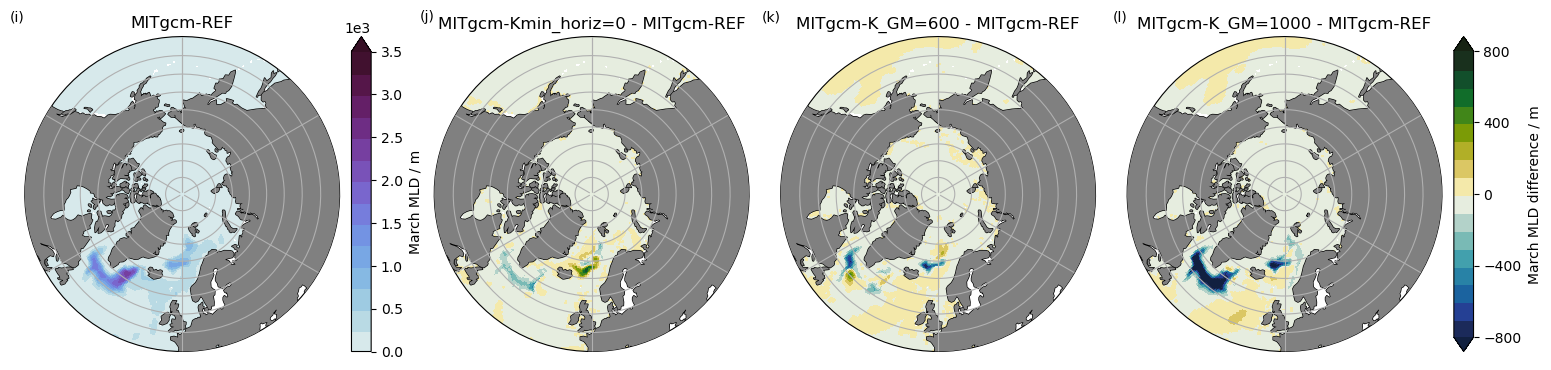

In [15]:
nextent=[-180, 180, 45, 90]
# sextent=[-180, 180, -90, -50]
proj=cart.crs.NorthPolarStereo()
#proj=cart.crs.PlateCarree() #central_longitude=161.)
hca, hcb = arrange_axes(npx,npy, plot_cb=[1,0,0,1], asp=1., fig_size_fac=2, daxt=1.2, dfigr=1.0, dcbr=1.6,
                        sharex=True, sharey=True, projection=proj,
                        do_axes_labels=False)
axlab(hca, figstr=figlabelstrs)
mymonth=3

dsloc = monthlyClim
for k in range(len(dsloc)):
    ax, cax = hca[k],hcb[k]
    # March
    mlnorm = colors.Normalize(vmin=0,vmax=3500)
    contfs = np.linspace(0,3500,15)
    extnd = 'max'
    clab = 'March MLD / m'
    if k==k0:
        bx, hm, gl = mapper(dsloc[k0].sel(month=mymonth).MXLDEPTH.where(mask2d),
                        ax=ax, tstr=("MITgcm-%s"%(fnames[k0])),
                        levels=contfs, extend=extnd, cmap=cmo.dense)
    else:
        contfs = np.linspace(-800,800,17)
        extnd = 'both'
        clab = 'March MLD difference / m'
        bx, hm, gl = mapper((dsloc[k]-dsloc[k0]).sel(month=mymonth).MXLDEPTH.where(mask2d),
                        ax=ax, tstr='MITgcm-%s - MITgcm-%s'%(fnames[k],fnames[k0]),
                        levels=contfs, extend=extnd, cmap=cmo.delta)
    bx.set_extent(nextent,cart.crs.PlateCarree())
    bx.set_boundary(circle, transform=bx.transAxes)
    gl.ylocator = mticker.FixedLocator(np.linspace(20,90,15))

    if (cax!=0) and (hm is not None): 
        cbkwargs = dict(orientation='vertical', extend=extnd, label=clab)
        cbticks=contfs[::4]
        if k==0: cbticks = np.linspace(0,3500,8)
        cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=cbticks, **cbkwargs)
        cb.solids.set_edgecolor("face")
        # make tick labels ugly again
        if k==0: cb.formatter.set_powerlimits((-3, 3))

if savefigs: plt.savefig(os.path.join(fdir,'mitgcm_mld_diff_march_nh'),dpi=300)

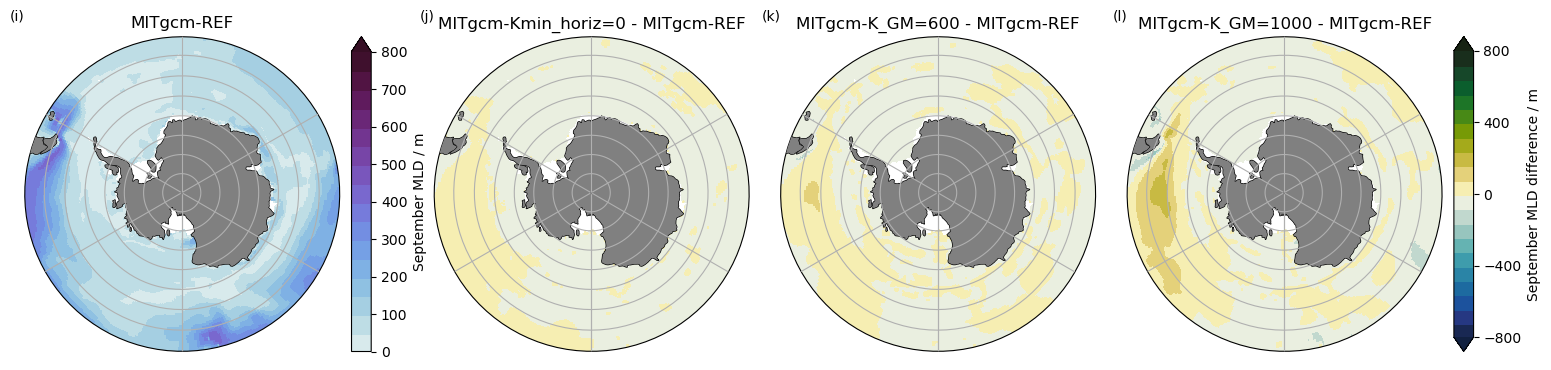

In [16]:
sextent=[-180, 180, -90, -50]
proj=cart.crs.SouthPolarStereo()
# september
mymonth=9

hca, hcb = arrange_axes(npx,npy, plot_cb=[1,0,0,1], asp=1., fig_size_fac=2, daxt=1.2, dfigr=1.0, dcbr=1.6,
                        sharex=True, sharey=True, projection=proj,
                        do_axes_labels=False)
axlab(hca, figstr=figlabelstrs)

for k in range(len(dsloc)):
    ax, cax = hca[k],hcb[k]
    contfs = np.linspace(0,800,17)
    extnd = 'max'
    clab = 'September MLD / m'
    if k==k0:
        bx, hm, gl = mapper(dsloc[k0].sel(month=mymonth).MXLDEPTH.where(mask2d),
                        ax=ax, tstr=("MITgcm-%s"%(fnames[k0])),
                        levels=contfs, extend=extnd, cmap=cmo.dense)
    else:
        contfs = np.linspace(-800,800,21)
        extnd = 'both'
        clab = 'September MLD difference / m'
        bx, hm, gl = mapper((dsloc[k]-dsloc[k0]).sel(month=mymonth).MXLDEPTH.where(mask2d),
                        ax=ax, tstr='MITgcm-%s - MITgcm-%s'%(fnames[k],fnames[k0]),
                        levels=contfs, extend=extnd, cmap=cmo.delta)
    bx.set_extent(sextent,cart.crs.PlateCarree())
    bx.set_boundary(circle, transform=bx.transAxes)
    gl.ylocator = mticker.FixedLocator(np.linspace(-90,-40,11))
    
    if (cax!=0) and (hm is not None): 
        cbkwargs = dict(orientation='vertical', extend=extnd, label=clab)
        cbticks=contfs[::5]
        if k==0: cbticks = contfs[::2]
        cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=cbticks, **cbkwargs)
        cb.solids.set_edgecolor("face")

#cb0 = plt.colorbar(mappable=hm,ax=bx,label='March MLD (m)')
#cb = colorbar(mappable=hm,ax=ax[1:],label='March MLD difference (m)')

if savefigs: put.savefig(os.path.join(fdir,'mitgcm_mld_diff_september_sh'),dpi=300)

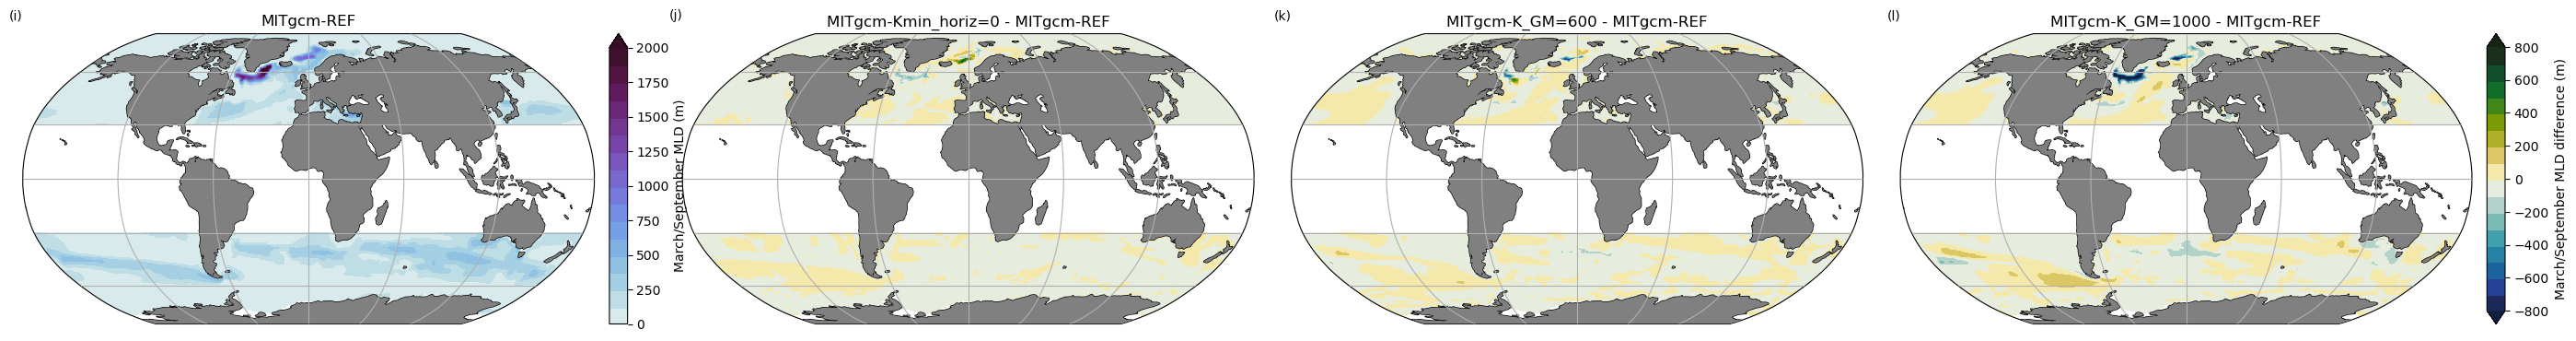

In [17]:
# combination plot
#proj=cart.crs.EqualEarth() #central_longitude=180.0-19) #central_longitude=7.0)
proj=cart.crs.Robinson() #central_longitude=180.0-19) #central_longitude=7.0)
#fig, ax = plt.subplots(nrows=1,ncols=4,sharex=True,sharey=True,figsize=(30,10),subplot_kw={'projection': proj})
npx, npy = 4,1
hca, hcb = arrange_axes(npx, npy, plot_cb=[1,0,0,1], asp=0.5, fig_size_fac=2,
                        sharex=True, sharey=True, dfigr=0.2, projection = proj,
                        do_axes_labels=False)
axlab(hca, figstr=figlabelstrs)
march = 3
sept  = 9
k0 = 0

# nmask2d=np.ma.masked_array( (dsloc[k0].hFacC.isel(k=0)!=0.) * (dsloc[k0].YC> 30.) ) #.compute()
# smask2d=np.ma.masked_array( (dsloc[k0].hFacC.isel(k=0)!=0.) * (dsloc[k0].YC<-30.) ) #.compute()
nmask2d=np.ma.masked_array( np.logical_and(mask2d,(dsloc[k0].YC> 30.)) )
smask2d=np.ma.masked_array( np.logical_and(mask2d,(dsloc[k0].YC<-30.)) )

for k,fname in enumerate(fnames): #[:2]):
    ax, cax = hca[k],hcb[k]
    # combine march and september value into one field
    mld = dsloc[k].isel(month=march).MXLDEPTH*np.where(nmask2d,1,0) + dsloc[k].isel(month=sept).MXLDEPTH*np.where(smask2d,1,0)
    mld = mld.where(np.logical_or(nmask2d,smask2d))
    if k==k0:
        mld0 = np.copy(mld)
        # contfs = np.linspace(0,3500,15)
        contfs = np.linspace(0,2000,17)
        extnd = 'max'
        clab = 'March/September MLD (m)'
        bx, hm, gl = mapper(mld, ax=ax, tstr=("MITgcm-%s"%(fnames[k0])),
                        levels=contfs, extend=extnd, cmap=cmo.dense)
    else:
        contfs = np.linspace(-800,800,17)
        extnd = 'both'
        clab = 'March/September MLD difference (m)'
        bx, hm, gl = mapper(mld - mld0, ax=ax, tstr='MITgcm-%s - MITgcm-%s'%(fnames[k],fnames[k0]),
                        levels=contfs, extend=extnd, cmap=cmo.delta)

    if (cax!=0) and (hm is not None): 
        cbkwargs = dict(orientation='vertical', extend=extnd, label=clab)
        cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=contfs[::2], **cbkwargs)
        cb.solids.set_edgecolor("face")

if savefigs: put.savefig(os.path.join(fdir,'mitgcm_mld_diff_March-September'),dpi=300)

# 12 deg isotherm

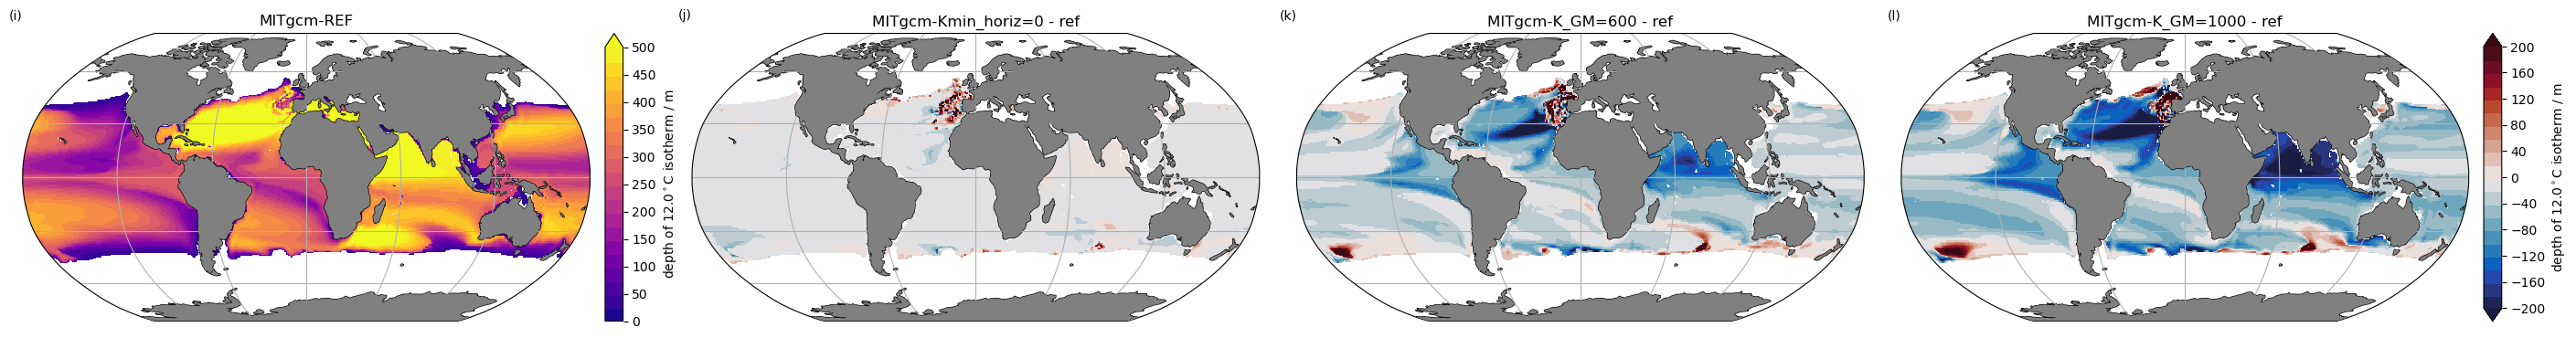

In [18]:
import pyresample

def isodepth( fld, fc, z, hf ):
    import numpy as np
    from scipy.interpolate import interp1d
    nz,nf,ny,nx = fld.shape
    nn = nf*ny*nx
    f2d = fld.reshape((nz,nn))
    zc   = np.zeros((nn))
    k_ind = np.ma.masked_array(f2d>=fc).sum(axis=0).data - 1
    hf2d = hf.reshape((nz,nn))
    for j in range(nn):
        kloc = k_ind[j]
        if kloc > 1 and kloc+1 < nz-1 and hf2d[kloc+1,j]>0.:
            f = interp1d(f2d[:,j],z)
            zc[j] = f(fc)
        elif k_ind[j] > 1:
            zc[j] = z[kloc]

    return zc.reshape((nf,ny,nx))


def plotisotherm(ds, fld, ax, tstr=None, levels=0, extend = 'both', dx=0.25, dy=0.25, **plt_kwargs):

    # Extract LLC 2D coordinates
    lons_1d = ds.XC.values.ravel()
    lats_1d = ds.YC.values.ravel()

    # Define original grid
    orig_grid = pyresample.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

    # Longitudes latitudes to which we will we interpolate
    lon_tmp = np.arange(-180, 180, dx) + dx/2
    lat_tmp = np.arange(-90, 90, dy) + dy/2

    # Define the lat lon points of the two parts.
    new_grid_lon, new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
    new_grid  = pyresample.geometry.GridDefinition(lons=new_grid_lon,
                                                        lats=new_grid_lat)

    field = pyresample.kd_tree.resample_nearest(orig_grid, fld,
                                                new_grid,
                                                radius_of_influence=100000,
                                                fill_value=None)

    x,y = new_grid_lon, new_grid_lat

    if False:
        p = ax.pcolormesh(new_grid_lon, new_grid_lat, field, 
                          transform=cart.crs.PlateCarree(), **plt_kwargs)
    else:
        p = ax.contourf(new_grid_lon, new_grid_lat, field, levels=levels, extend=extend, 
                        transform=cart.crs.PlateCarree(), **plt_kwargs)

    # ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
    ax.add_feature(cart.feature.LAND, facecolor=landcolor, zorder=3)
    ax.coastlines(color='k')
    gl = ax.gridlines()

    if tstr is not None:
        ax.set_title('%s'%(tstr))
  
    return p, gl

#proj=cart.crs.EqualEarth() #central_longitude=180.0-19) #central_longitude=7.0)
proj=cart.crs.Robinson() #central_longitude=180.0-19) #central_longitude=7.0)
#fig, ax = plt.subplots(nrows=1,ncols=4,sharex=True,sharey=True,figsize=(30,10),subplot_kw={'projection': proj})
npx, npy = 4,1
hca, hcb = arrange_axes(npx, npy, plot_cb=[1,0,0,1], asp=0.5, fig_size_fac=2,
                        sharex=True, sharey=True, dfigr=0.2, projection = proj, dcbr=1.8,
                        do_axes_labels=False)
axlab(hca, figstr=figlabelstrs)

for k,fname in enumerate(fnames): #[:2]):
    ax, cax = hca[k],hcb[k]
    depth12C = -isodepth( dsm[k].THETA.values, 12., dsm[k].Z.values, dsm[k].hFacC.values )
    cmap  = plt.get_cmap('plasma')
    dnorm = colors.Normalize(vmin=0,vmax=500)
    # depth12C0 = np.copy(depth12C)
    tstr = 'MITgcm-%s'%(fname)
    if k == 0:
        depth12C0 = np.copy(depth12C)
        contfs = np.linspace(0,500,21)
        extnd = 'max'
        clab = r'depth of 12.0$^\circ$C isotherm / m'
    else:
        depth12C = depth12C - depth12C0
        cmap  = cmo.balance
        contfs = np.linspace(-200,200,21)
        extnd = 'both'
        vm = 200
        dnorm = colors.Normalize(vmin=-vm,vmax=vm)
        tstr = 'MITgcm-%s - ref'%(fname)
        cblab = 'depth difference of 12.0$^\circ$C isotherm / m'
        
    hm, gl = plotisotherm(dsm[k],sq(depth12C),ax, tstr, levels = contfs, extend = extnd, norm = dnorm, cmap = cmap)
    if (cax!=0) and (hm is not None): 
        cbkwargs = dict(orientation='vertical', extend=extnd, label=clab)
        cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=contfs[::2], **cbkwargs)
        cb.solids.set_edgecolor("face")

if savefigs: put.savefig(os.path.join(fdir,'mitgcm_12deg_isotherm_depth'),dpi=300)

# Overturning

In [19]:
# values at 20N and 20S
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)

y = xr.concat([coords.YG.isel(face= 0),coords.YG.isel(face= 1),coords.YG.isel(face= 2)], dim='j_g').mean(dim='i_g')

def save_moc(dl,msk,fname):
    y20S = 140
    y20N = 190
    mocstrf = compute_moc_layers(dl,msk)
    zlayer = -compute_layers(dlm[k],msk)
    myfname = "%s_20N.txt"%(fname)
    np.savetxt(os.path.join(fdir,myfname),(zlayer[:,y20N],mocstrf[:,y20N]))
    myfname = "%s_20S.txt"%(fname)
    print(myfname)
    np.savetxt(os.path.join(fdir,myfname),(zlayer[:,y20S],mocstrf[:,y20S]))

for k,fname in enumerate(fnames):
    save_moc(dlm[k],global_mask,"%s_global"%(fname))
    save_moc(dlm[k],atlantic_mask,"%s_atlantic"%(fname))
    save_moc(dlm[k],indopacific_mask,"%s_indopacific"%(fname))



REF_global_20S.txt
REF_atlantic_20S.txt
REF_indopacific_20S.txt
Kmin_horiz=0_global_20S.txt
Kmin_horiz=0_atlantic_20S.txt
Kmin_horiz=0_indopacific_20S.txt
K_GM=600_global_20S.txt
K_GM=600_atlantic_20S.txt
K_GM=600_indopacific_20S.txt
K_GM=1000_global_20S.txt
K_GM=1000_atlantic_20S.txt
K_GM=1000_indopacific_20S.txt


In [20]:
from scipy.interpolate import interp1d

def plotmoc_remapped(ax,ds,dl,msk,levs,cmap,tstr='dummy'):
    mocstrf = compute_moc_layers(dl,msk)
    zlayer = compute_layers(dl,msk)
    y = xr.concat([coords.YG.isel(face= 0),coords.YG.isel(face= 1),coords.YG.isel(face= 2)], dim='j_g').mean(dim='i_g')
    nl = zlayer.shape[0]
    yl = np.tile(y.data.reshape((1,y.shape[0])),(nl,1))
    csf=ax.contourf(yl,zlayer,(mocstrf)*1e-6,levels=levs,cmap=cmap, extend='both')
    nlv = 20
    lwdths = 0.5*np.ones((9,))
    lwdths[4] = 1.5
    cs =ax.contour( yl,zlayer,(mocstrf)*1e-6,levels=np.linspace(-nlv,nlv,9),colors='k',linewidths=lwdths)
    ax.clabel(cs, cs.levels, inline=True, fontsize=10, fmt='%.1f Sv')
    # ylimit=-6000
    # d = flat2d(ds.Depth*msk).max(axis=-1)
    # ax.fill_between(y,-d,ylimit,step='mid',facecolor=landcolor)
    # ax.set_ylim([ylimit,0])
    ax.set_facecolor(landcolor)
    ax.set_title('MITgcm-%s'%(tstr))
    ax.grid()
    
    return csf
    
# def plotmoc_remapped_div(ax,ds,dl,msk,levs,cmap,tstr='dummy'):
#     mocstrf = compute_moc_layers_div(dl,msk)
#     rhoZonalMean = zonal_mean(ds,ds.LaTr1RHO,msk).data
#     psir_z = np.zeros(rhoZonalMean.shape)
#     # it is cheaper to define the interpolator once and only use part of
#     # it than to define a new one for each latitude
#     f = interp1d(dl.layer_1RHO_center, mocstrf, axis=0, bounds_error = False, fill_value=0)
#     # f = interp1d(dl.layer_1RHO_bounds[1:], mocstrf, axis=0, bounds_error = False, fill_value=0)
#     for jj in range(mocstrf.shape[1]):
#         psir_z[:,jj] = f(rhoZonalMean[:,jj])[:,jj]

#     dd = flat2d(ds.Depth*msk)
#     d = dd.max(axis=-1)
#     y = xr.concat([coords.YG.isel(face= 0),coords.YG.isel(face= 1),coords.YG.isel(face= 2)], dim='j_g').mean(dim='i_g')
#     csf=ax.contourf(y,ds.Z,sq(psir_z)*1e-6,levels=levs,cmap=cmap, extend='both')
#     cs1=ax.contour(y,ds.Z,sq(psir_z)*1e-6,levels=np.linspace(-20,20,17),colors='k',linestyles='solid',linewidths=0.5)
#     ax.clabel(cs1, cs1.levels, inline=True, fontsize=10)
#     ylimit=-ds.drF.sum()-200
#     ax.fill_between(y,-d,ylimit,step='mid',facecolor=landcolor)
#     #ax.set_ylim([ylimit,0])
#     ax.set_title('MITgcm-%s'%(tstr))
#     ax.grid() 
#     return csf

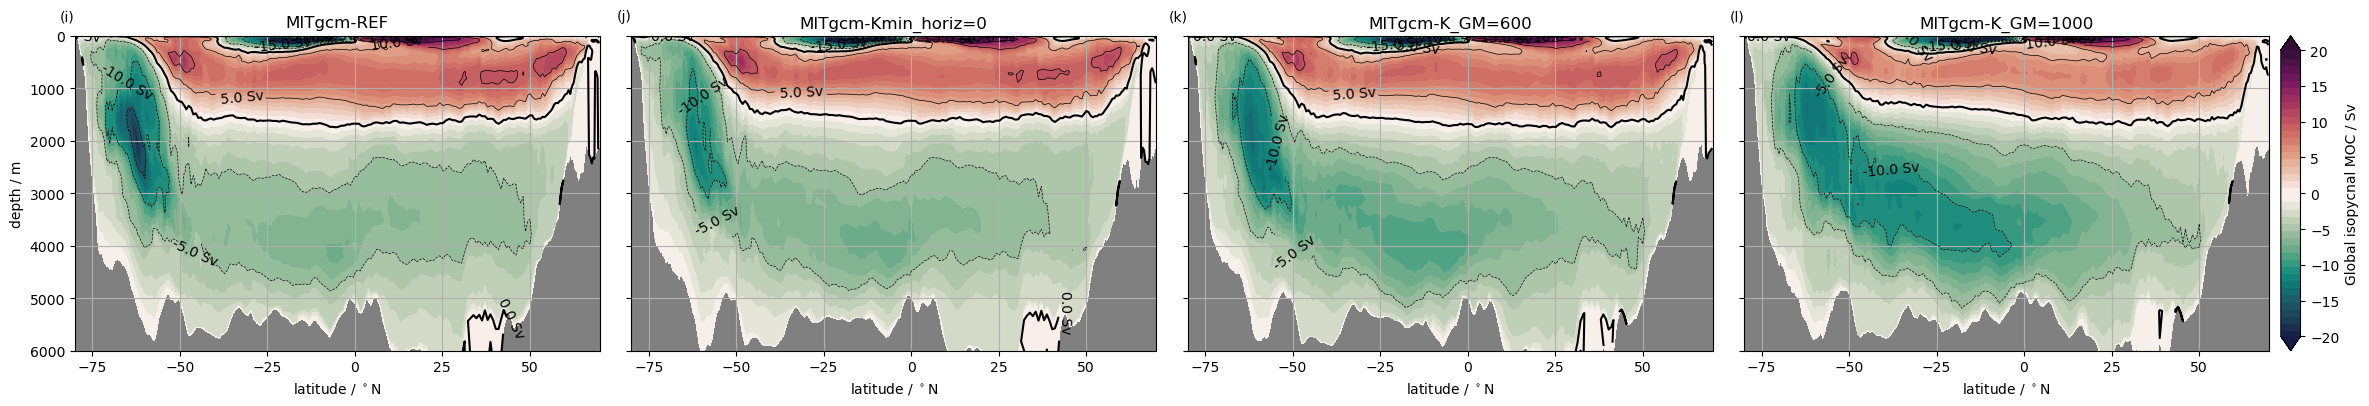

In [21]:
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)

npx, npy = 4,1
hca, hcb = arrange_axes(npx, npy, plot_cb='right', asp=0.6, fig_size_fac=2,
                        sharex=True, sharey=True, xlabel='latitude / $^\circ$N', ylabel='depth / m',
                        do_axes_labels=False)
axlab(hca, figstr=figlabelstrs)

contfs = np.linspace(-20,20,41)
#contfs = np.linspace(-20,20,17)
cmap=cmo.curl
for k,fname in enumerate(fnames):
    ax, cax = hca[k],hcb[k]
    hm = plotmoc_remapped(ax,dsm[k],dlm[k],     global_mask,contfs,cmap,tstr=fname)
    ax.set_xlim([-80,70])
    ax.set_ylim([6000,0])
    ax.set_xticks([-75,-50,-25,0,25,50])
    if (cax!=0) and (hm is not None): 
        cbkwargs = dict(orientation='vertical', extend='both')
        cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=contfs[::5], **cbkwargs)
        cb.solids.set_edgecolor("face")
    
hcb[-1].set_ylabel('Global isopycnal MOC / Sv')
#y0,y1 = dl0.time.isel(time=0),dl0.time.isel(time=-1)
#fig.suptitle('Overturning streamfunction $\Psi$ (Sv), years %s-%s'%(y0.data.astype('datetime64[Y]'),y1.data.astype('datetime64[Y]')))
#fig.suptitle('Overturning streamfunction $\Psi$ (Sv), years %s-%s'%(year0,year1))
if savefigs: put.savefig(os.path.join(fdir,'mitgcm_global_dmoc_remapped'))

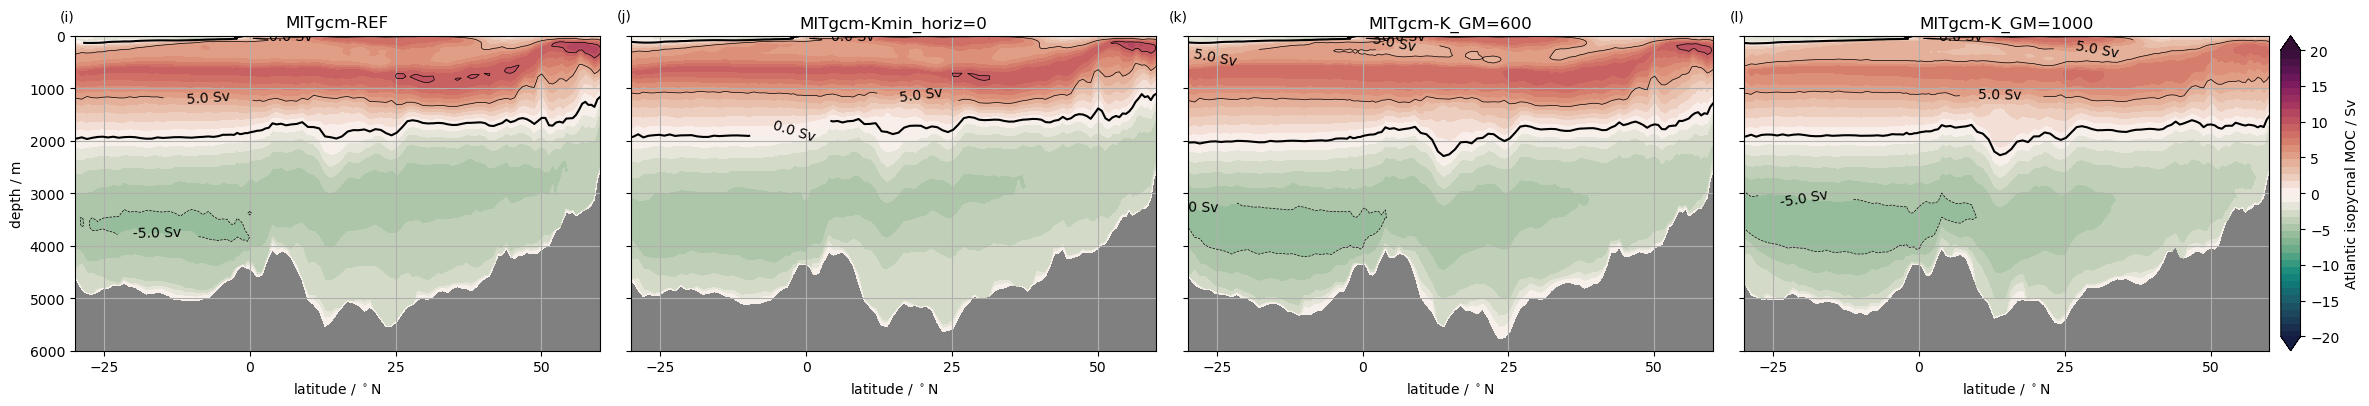

In [22]:
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)

npx, npy = 4,1
hca, hcb = arrange_axes(npx, npy, plot_cb='right', asp=0.6, fig_size_fac=2,
                        sharex=True, sharey=True, xlabel='latitude / $^\circ$N', ylabel='depth / m',
                        do_axes_labels=False)
axlab(hca, figstr=figlabelstrs)

contfs = np.linspace(-20,20,41)
cmap=cmo.curl
for k,fname in enumerate(fnames):
    ax, cax = hca[k],hcb[k]
    hm = plotmoc_remapped(ax,dsm[k],dlm[k],atlantic_mask,contfs,cmap,tstr=fname)
    ax.set_xlim([-30,60])
    ax.set_xticks([-25,0,25,50])
    ax.set_ylim([6000,0])
    if (cax!=0) and (hm is not None): 
        cbkwargs = dict(orientation='vertical', extend='both')
        cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=contfs[::5], **cbkwargs)
        cb.solids.set_edgecolor("face")

hcb[-1].set_ylabel('Atlantic isopycnal MOC / Sv')
#y0,y1 = dl0.time.isel(time=0),dl0.time.isel(time=-1)
#fig.suptitle('Overturning streamfunction $\Psi$ (Sv), years %s-%s'%(y0.data.astype('datetime64[Y]'),y1.data.astype('datetime64[Y]')))
#fig.suptitle('Overturning streamfunction $\Psi$ (Sv), years %s-%s'%(year0,year1))
if savefigs: put.savefig(os.path.join(fdir,'mitgcm_atlantic_dmoc_remapped'))

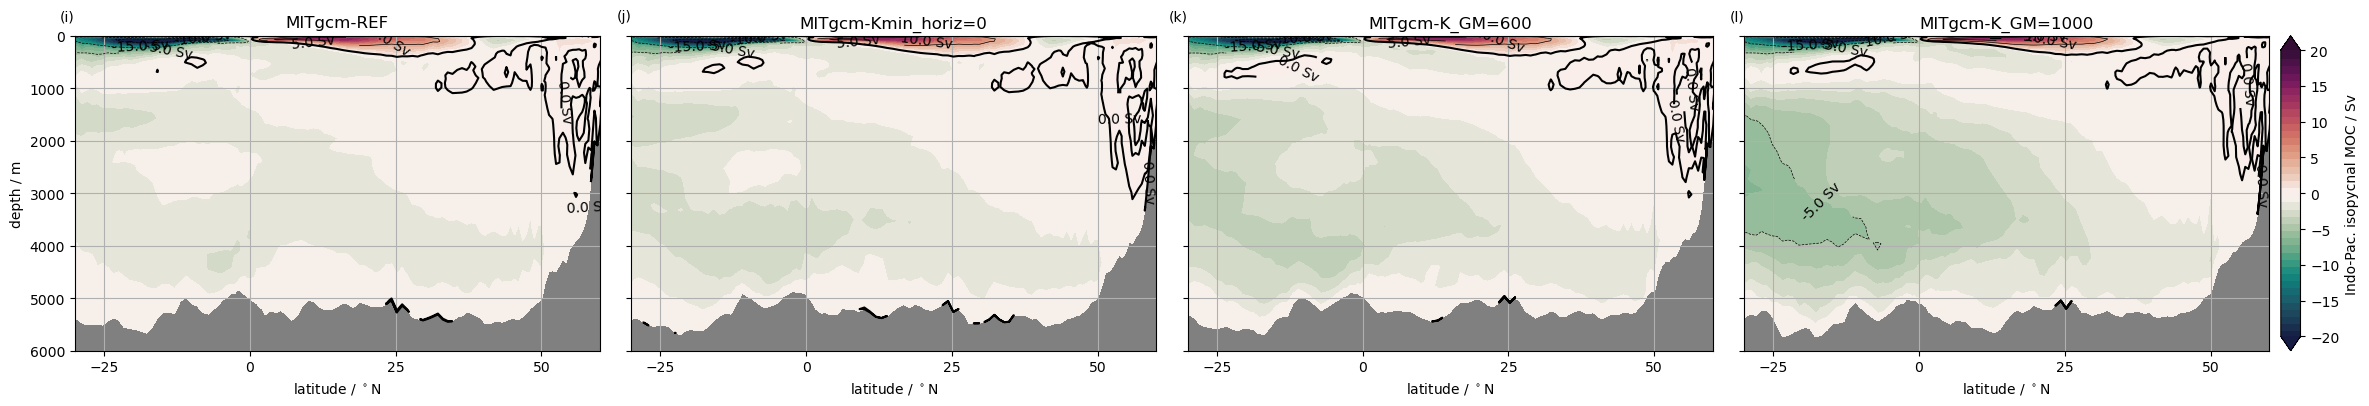

In [23]:
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)

npx, npy = 4,1
hca, hcb = arrange_axes(npx, npy, plot_cb='right', asp=0.6, fig_size_fac=2,
                        sharex=True, sharey=True, xlabel='latitude / $^\circ$N', ylabel='depth / m',
                        do_axes_labels=False)
axlab(hca, figstr=figlabelstrs)

contfs = np.linspace(-20,20,41)
cmap=cmo.curl
for k,fname in enumerate(fnames):
    ax, cax = hca[k],hcb[k]
    hm = plotmoc_remapped(ax,dsm[k],dlm[k],indopacific_mask,contfs,cmap,tstr=fname)
    ax.set_xlim([-30,60])
    ax.set_ylim([6000,0])
    ax.set_xticks([-25,0,25,50])
    if (cax!=0) and (hm is not None): 
        cbkwargs = dict(orientation='vertical', extend='both')
        cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=contfs[::5], **cbkwargs)
        cb.solids.set_edgecolor("face")

hcb[-1].set_ylabel('Indo-Pac. isopycnal MOC / Sv')
#y0,y1 = dl0.time.isel(time=0),dl0.time.isel(time=-1)
#fig.suptitle('Overturning streamfunction $\Psi$ (Sv), years %s-%s'%(y0.data.astype('datetime64[Y]'),y1.data.astype('datetime64[Y]')))
if savefigs: put.savefig(os.path.join(fdir,'mitgcm_indo_pacific_dmoc_remapped'))

In [24]:
def compute_moc_layers_remapped(ds,dl,msk):
    mocstrf = compute_moc_layers(dl,msk)
    rhoZonalMean = zonal_mean(ds,ds.LaTr1RHO,msk).data
    psir_z = np.zeros(rhoZonalMean.shape)
    # it is cheaper to define the interpolator once and only use part of
    # it than to define a new one for each latitude
    f = interp1d(dl.layer_1RHO_center, mocstrf, axis=0, bounds_error = False, fill_value=0)
    for jj in range(mocstrf.shape[1]):
        psir_z[:,jj] = f(rhoZonalMean[:,jj])[:,jj]
    return psir_z

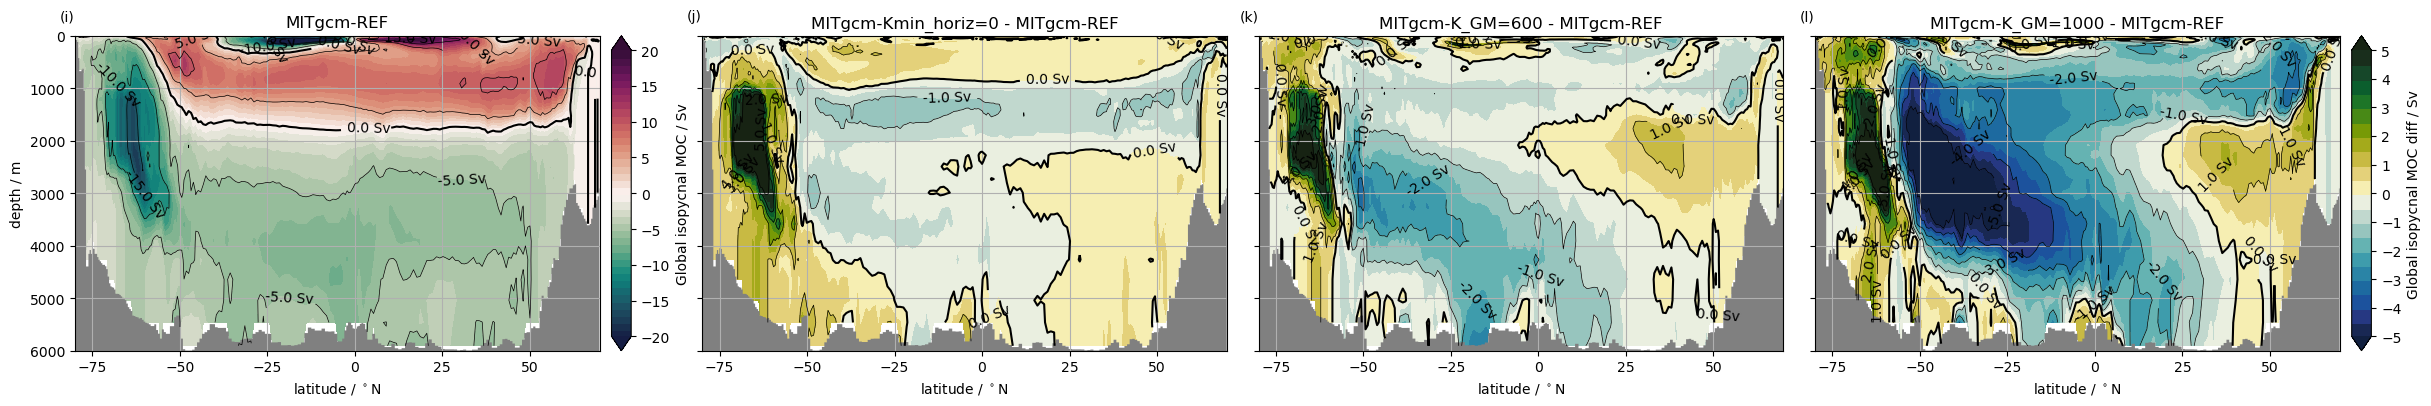

In [25]:
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)

npx, npy = 4,1
hca, hcb = arrange_axes(npx, npy, plot_cb=[1,0,0,1], asp=0.6, fig_size_fac=2,
                        sharex=True, sharey=True, xlabel='latitude / $^\circ$N', ylabel='depth / m', dcbr=1.8,
                        do_axes_labels=False)
axlab(hca, figstr=figlabelstrs)

dd = flat2d(dsm[0].Depth*global_mask)
d = dd.max(axis=-1)
y = xr.concat([coords.YG.isel(face= 0),coords.YG.isel(face= 1),coords.YG.isel(face= 2)], dim='j_g').mean(dim='i_g')

contfs0 = np.linspace(-20,20,41)
contfs1 = np.linspace(-5,5,21)
cmap=cmo.curl

for k,fname in enumerate(fnames):
    ax, cax = hca[k],hcb[k]
    if k==0:
        psir_z0 = compute_moc_layers_remapped(dsm[k],dlm[k],global_mask)
        lwdths = 0.5*np.ones((9,))
        lwdths[4] = 1.5
        hm=ax.contourf(y,-dsm[k].Z,sq(psir_z0)*1e-6,levels=contfs0,cmap=cmap, extend='both')
        cs=ax.contour(y,-dsm[k].Z,sq(psir_z0)*1e-6,levels=np.linspace(-20,20,9),colors='k',linestyles='solid',linewidths=lwdths)
        ax.clabel(cs, cs.levels, inline=True, fontsize=10, fmt='%.1f Sv')
        ax.set_title('MITgcm-%s'%(fname))
        contfs=contfs0[::5]
#        hm = plotmoc_remapped(ax,dsm[k],dlm[k],global_mask,contfs0,cmap,tstr=fname)
    else:
        psir_z = compute_moc_layers_remapped(dsm[k],dlm[k],global_mask)
        lwdths = 0.5*np.ones((11,))
        lwdths[5] = 1.5
        hm=ax.contourf(y,-dsm[k].Z,sq(psir_z - psir_z0)*1e-6,levels=contfs1,cmap=cmo.delta, extend='both')
        cs=ax.contour(y,-dsm[k].Z,sq(psir_z - psir_z0)*1e-6,levels=np.linspace(-5,5,11),colors='k',linestyles='solid',linewidths=lwdths)
        ax.clabel(cs, cs.levels, inline=True, fontsize=10, fmt='%.1f Sv')
        ax.set_title('MITgcm-%s - MITgcm-REF'%(fname))
        contfs=contfs1[::2]

    ylimit=-dsm[0].drF.sum()-200
    ax.fill_between(y,d,-ylimit,step='mid',facecolor=landcolor)
    #ax.set_ylim([ylimit,0])
    ax.grid() 
    ax.set_xlim([-80,70])
    ax.set_ylim([6000,0])
    ax.set_xticks([-75,-50,-25,0,25,50])
    if (cax!=0) and (hm is not None): 
        cbkwargs = dict(orientation='vertical', extend='both')
        cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=contfs, **cbkwargs)
        cb.solids.set_edgecolor("face")

hcb[0].set_ylabel('Global isopycnal MOC / Sv')
hcb[-1].set_ylabel('Global isopycnal MOC diff / Sv')
#y0,y1 = dl0.time.isel(time=0),dl0.time.isel(time=-1)
#fig.suptitle('Overturning streamfunction $\Psi$ (Sv), years %s-%s'%(y0.data.astype('datetime64[Y]'),y1.data.astype('datetime64[Y]')))
#fig.suptitle('Overturning streamfunction $\Psi$ (Sv), years %s-%s'%(year0,year1))
if savefigs: put.savefig(os.path.join(fdir,'mitgcm_global_dmoc_remapped_diff'))

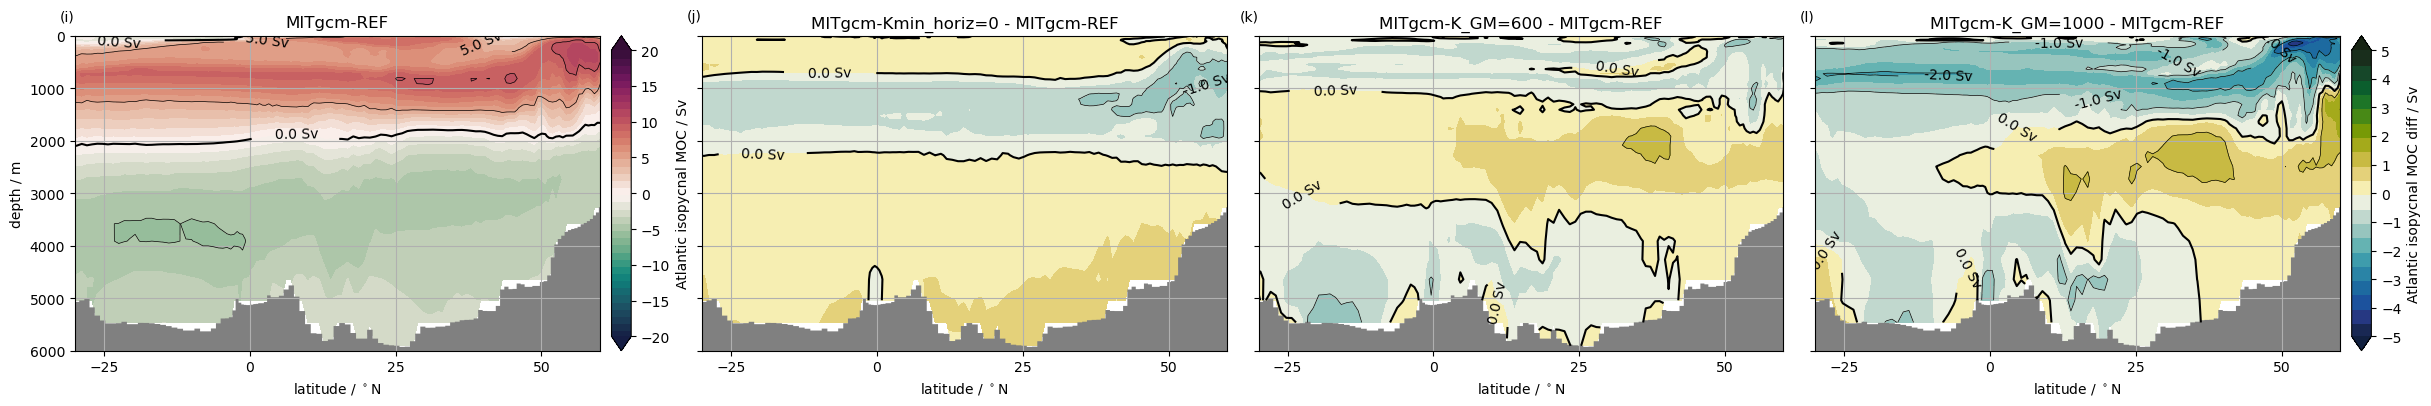

In [26]:
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)

npx, npy = 4,1
hca, hcb = arrange_axes(npx, npy, plot_cb=[1,0,0,1], asp=0.6, fig_size_fac=2,
                        sharex=True, sharey=True, xlabel='latitude / $^\circ$N', ylabel='depth / m', dcbr=1.8,
                        do_axes_labels=False)
axlab(hca, figstr=figlabelstrs)

dd = flat2d(dsm[0].Depth*atlantic_mask)
d = dd.max(axis=-1)
y = xr.concat([coords.YG.isel(face= 0),coords.YG.isel(face= 1),coords.YG.isel(face= 2)], dim='j_g').mean(dim='i_g')

contfs0 = np.linspace(-20,20,41)
contfs1 = np.linspace(-5,5,21)
cmap=cmo.curl

for k,fname in enumerate(fnames):
    ax, cax = hca[k],hcb[k]
    if k==0:
        psir_z0 = compute_moc_layers_remapped(dsm[k],dlm[k],atlantic_mask)
        lwdths = 0.5*np.ones((9,))
        lwdths[4] = 1.5
        hm=ax.contourf(y,-dsm[k].Z,sq(psir_z0)*1e-6,levels=contfs0,cmap=cmap, extend='both')
        cs=ax.contour(y,-dsm[k].Z,sq(psir_z0)*1e-6,levels=np.linspace(-20,20,9),colors='k',linestyles='solid',linewidths=lwdths)
        ax.clabel(cs, cs.levels, inline=True, fontsize=10, fmt='%.1f Sv')
        ax.set_title('MITgcm-%s'%(fname))
        contfs=contfs0[::5]
#        hm = plotmoc_remapped(ax,dsm[k],dlm[k],atlantic_mask,contfs0,cmap,tstr=fname)
    else:
        psir_z = compute_moc_layers_remapped(dsm[k],dlm[k],atlantic_mask)
        lwdths = 0.5*np.ones((11,))
        lwdths[5] = 1.5
        hm=ax.contourf(y,-dsm[k].Z,sq(psir_z - psir_z0)*1e-6,levels=contfs1,cmap=cmo.delta, extend='both')
        cs=ax.contour(y,-dsm[k].Z,sq(psir_z - psir_z0)*1e-6,levels=np.linspace(-5,5,11),colors='k',linestyles='solid',linewidths=lwdths)
        ax.clabel(cs, cs.levels, inline=True, fontsize=10, fmt='%.1f Sv')
        ax.set_title('MITgcm-%s - MITgcm-REF'%(fname))
        contfs=contfs1[::2]

    ylimit=-dsm[0].drF.sum()-200
    ax.fill_between(y,d,-ylimit,step='mid',facecolor=landcolor)
    #ax.set_ylim([ylimit,0])
    ax.grid() 
    ax.set_xlim([-30,60])
    ax.set_xticks([-25,0,25,50])
    ax.set_ylim([6000,0])
    if (cax!=0) and (hm is not None): 
        cbkwargs = dict(orientation='vertical', extend='both')
        cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=contfs, **cbkwargs)
        cb.solids.set_edgecolor("face")

hcb[0].set_ylabel('Atlantic isopycnal MOC / Sv')
hcb[-1].set_ylabel('Atlantic isopycnal MOC diff / Sv')
#y0,y1 = dl0.time.isel(time=0),dl0.time.isel(time=-1)
#fig.suptitle('Overturning streamfunction $\Psi$ (Sv), years %s-%s'%(y0.data.astype('datetime64[Y]'),y1.data.astype('datetime64[Y]')))
#fig.suptitle('Overturning streamfunction $\Psi$ (Sv), years %s-%s'%(year0,year1))
if savefigs: put.savefig(os.path.join(fdir,'mitgcm_atlantic_dmoc_remapped_diff'))

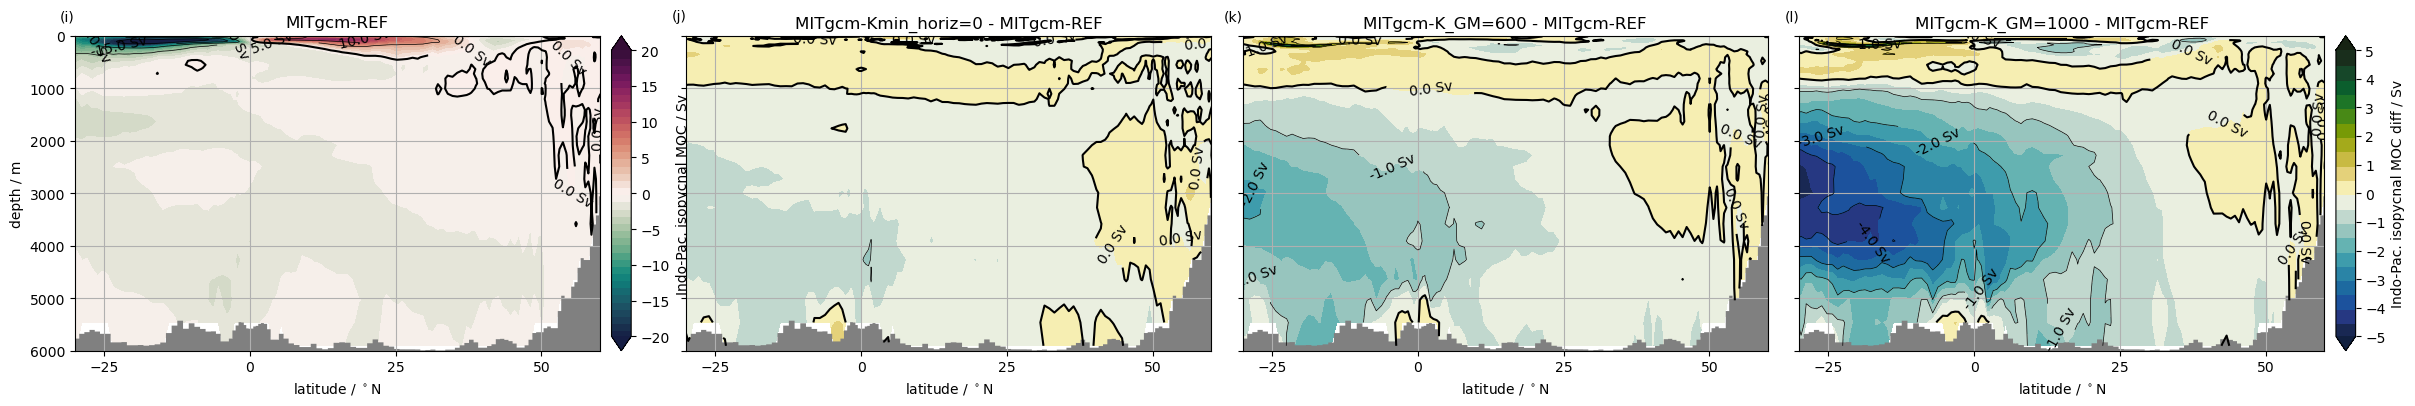

In [27]:
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)

npx, npy = 4,1
hca, hcb = arrange_axes(npx, npy, plot_cb=[1,0,0,1], asp=0.6, fig_size_fac=2,
                        sharex=True, sharey=True, xlabel='latitude / $^\circ$N', ylabel='depth / m',
                        do_axes_labels=False)
axlab(hca, figstr=figlabelstrs)

dd = flat2d(dsm[0].Depth*indopacific_mask)
d = dd.max(axis=-1)
y = xr.concat([coords.YG.isel(face= 0),coords.YG.isel(face= 1),coords.YG.isel(face= 2)], dim='j_g').mean(dim='i_g')

contfs0 = np.linspace(-20,20,41)
contfs1 = np.linspace(-5,5,21)
cmap=cmo.curl

for k,fname in enumerate(fnames):
    ax, cax = hca[k],hcb[k]
    if k==0:
        psir_z0 = compute_moc_layers_remapped(dsm[k],dlm[k],indopacific_mask)
        lwdths = 0.5*np.ones((9,))
        lwdths[4] = 1.5
        hm=ax.contourf(y,-dsm[k].Z,sq(psir_z0)*1e-6,levels=contfs0,cmap=cmap, extend='both')
        cs=ax.contour(y,-dsm[k].Z,sq(psir_z0)*1e-6,levels=np.linspace(-20,20,9),colors='k',linestyles='solid',linewidths=lwdths)
        ax.clabel(cs, cs.levels, inline=True, fontsize=10, fmt='%.1f Sv')
        ax.set_title('MITgcm-%s'%(fname))
        contfs=contfs0[::5]
#        hm = plotmoc_remapped(ax,dsm[k],dlm[k],indopacific_mask,contfs0,cmap,tstr=fname)
    else:
        psir_z = compute_moc_layers_remapped(dsm[k],dlm[k],indopacific_mask)
        lwdths = 0.5*np.ones((11,))
        lwdths[5] = 1.5
        hm=ax.contourf(y,-dsm[k].Z,sq(psir_z - psir_z0)*1e-6,levels=contfs1,cmap=cmo.delta, extend='both')
        cs=ax.contour(y,-dsm[k].Z,sq(psir_z - psir_z0)*1e-6,levels=np.linspace(-5,5,11),colors='k',linestyles='solid',linewidths=lwdths)
        ax.clabel(cs, cs.levels, inline=True, fontsize=10, fmt='%.1f Sv')
        ax.set_title('MITgcm-%s - MITgcm-REF'%(fname))
        contfs=contfs1[::2]

    ylimit=-dsm[0].drF.sum()-200
    ax.fill_between(y,d,-ylimit,step='mid',facecolor=landcolor)
    #ax.set_ylim([ylimit,0])
    ax.grid() 
    ax.set_xlim([-30,60])
    ax.set_xticks([-25,0,25,50])
    ax.set_ylim([6000,0])
    if (cax!=0) and (hm is not None): 
        cbkwargs = dict(orientation='vertical', extend='both')
        cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=contfs, **cbkwargs)
        cb.solids.set_edgecolor("face")

hcb[0].set_ylabel('Indo-Pac. isopycnal MOC / Sv')
hcb[-1].set_ylabel('Indo-Pac. isopycnal MOC diff / Sv')
if savefigs: put.savefig(os.path.join(fdir,'mitgcm_indo_pacific_dmoc_remapped_diff'))

# Sections

In [28]:
def section170(ds,fld):
    jj=48 # XC = 169.5
#   jj=49 # XC = 168.5
    fldSection=np.concatenate((fld[:,7,jj,:],fld[:,8,jj,:],fld[:,9,jj,:]),axis=1)[:,:-30]
    y = np.concatenate(grid.YC[7:10,jj,:],axis=0)[:-30]
    d = np.concatenate(ds.Depth[7:10,jj,:],axis=0)[:-30]
    z = ds.Z.values
    return y, z, d, fldSection

def section30(ds,fld):
    ii=7
    iface=3
    fldSection=np.concatenate((fld[:,0,:,ii],fld[:,1,:,ii],fld[:,2,:,ii]),axis=1)
    y = np.concatenate(grid.YC[:iface,:,ii],axis=0)
    d = np.concatenate(ds.Depth[:iface,:,ii],axis=0)
    z = ds.Z.values
    return y, z, d, fldSection

def plotsec(ax, cax, data_x, data_y, data_v, contfs, fname):
    hm=ax.contourf(data_x, -data_y, data_v, levels=contfs, vmin=contfs[0], vmax=contfs[-1], 
                   cmap=cmap, norm=norm, extend='both')
    ax.fill_between(data_x,depth,6000,step='mid',facecolor=landcolor)
    ax.set_title('MITgcm-%s'%fname)
    plot_settings(ax=ax, template='section',xlim=[-80,60])
    # colorbar
    cbkwargs = dict(orientation='vertical', extend='both')
    cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=contfs, **cbkwargs)
    cb.solids.set_edgecolor("face")
    cb.set_ticks(contfs[contfs!=0.0])
    cb.ax.yaxis.set_major_formatter(mticker.LogFormatterSciNotation())
    


## mixing properties

### buoyancy

/tmp/ipykernel_3842424/1195796712.py:19: UserWarning: Log scale: values of z <= 0 have been masked
  hm=ax.contourf(data_x, -data_y, sq(data_v), levels=contfs, cmap=cmap, norm=norm, extend='both')


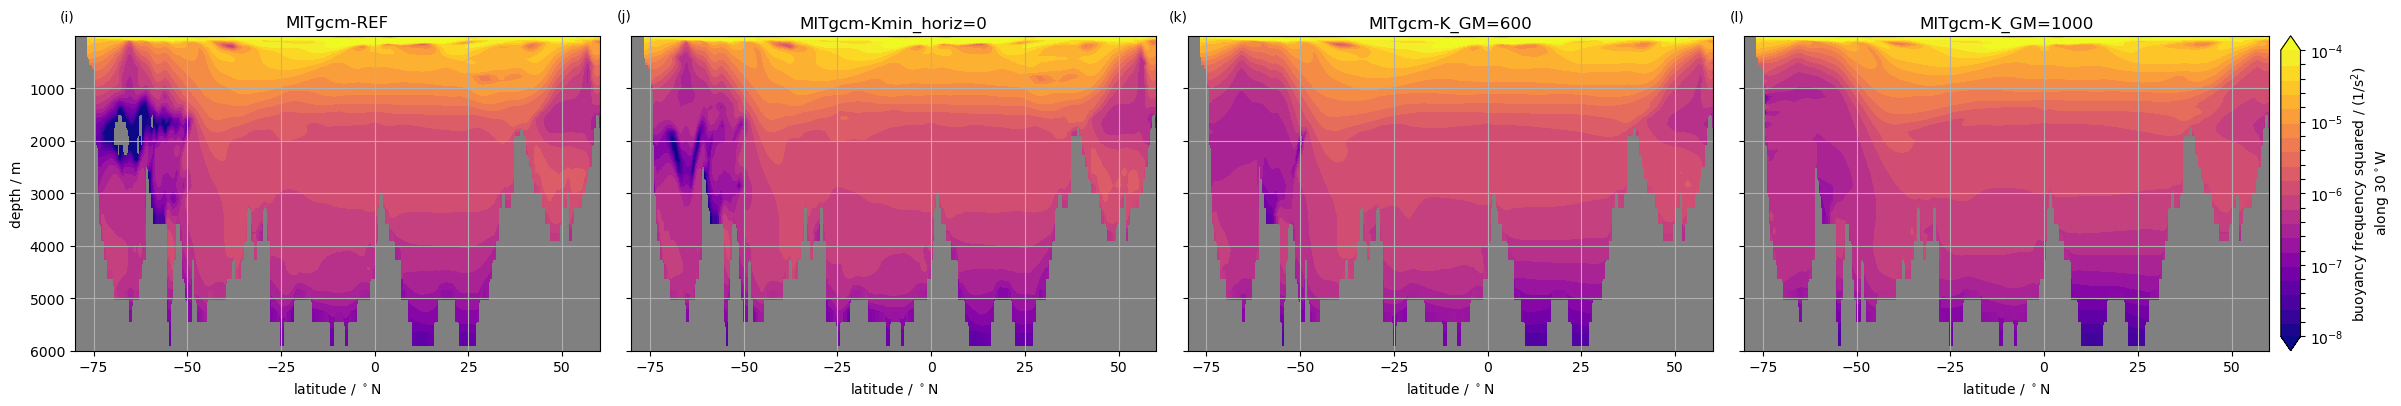

In [29]:
npx, npy = 4,1
hca, hcb = arrange_axes(npx, npy, plot_cb='right', asp=0.6, fig_size_fac=2,
                        sharex=True, sharey=True, xlabel='latitude / $^\circ$N', ylabel='depth / m',
                        do_axes_labels=False)
axlab(hca, figstr=figlabelstrs) 

clim, norm, contfs = get_log_clevs([-8, -4])

for ii,fname in enumerate(fnames):
    ax, cax = hca[ii],hcb[ii]
    cmap = plt.get_cmap('plasma')
    data_x, data_y, depth, data_v = section30(dsm[ii],-9.81/1035 * dsm[ii].DRHODR)
    data_y = dsm[ii].Zu.data
    # plotsec(ax, cax, data_x, data_y, data_v, contfs, fname)
    # hm=ax.contourf(data_x, -data_y, sq(data_v), levels=contfs, vmin=contfs[0], vmax=contfs[-1], 
    #               cmap=cmap, norm=norm, extend='both')
    hm=ax.pcolormesh(data_x, -data_y, sq(data_v), cmap=cmap, norm=norm)
    #ax.contour(data_x, -data_y, sq(data_v), levels=contfs, colors = 'k', linewidths=0.5)
    hm=ax.contourf(data_x, -data_y, sq(data_v), levels=contfs, cmap=cmap, norm=norm, extend='both')
    #ax.fill_between(data_x,depth,6000,step='mid',facecolor=landcolor)
    #___________________________________________________________________________________
    # This is out of Niels pyicon.shade(...) routine
    if (cax!=0) and (hm is not None): 
        cbkwargs = dict(orientation='vertical', extend='both')
        cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=contfs, **cbkwargs)
        cb.solids.set_edgecolor("face")
        cb.set_ticks(contfs[contfs!=0.0])
        cb.ax.yaxis.set_major_formatter(mticker.LogFormatterSciNotation())

    #___________________________________________________________________________________  
    ax.set_title('MITgcm-%s'%fname)
    plot_settings(ax=ax, template='section',xlim=[-80,60])

cax.set_ylabel(f'buoyancy frequency squared / (1/s$^2$)\n along 30$^\circ$W')
if savefigs: put.savefig(os.path.join(fdir,'mitgcm_buoyfreq2_30w'))

/tmp/ipykernel_3842424/1129218295.py:19: UserWarning: Log scale: values of z <= 0 have been masked
  hm=ax.contourf(data_x, -data_y, sq(data_v), levels=contfs, cmap=cmap, norm=norm, extend='both')


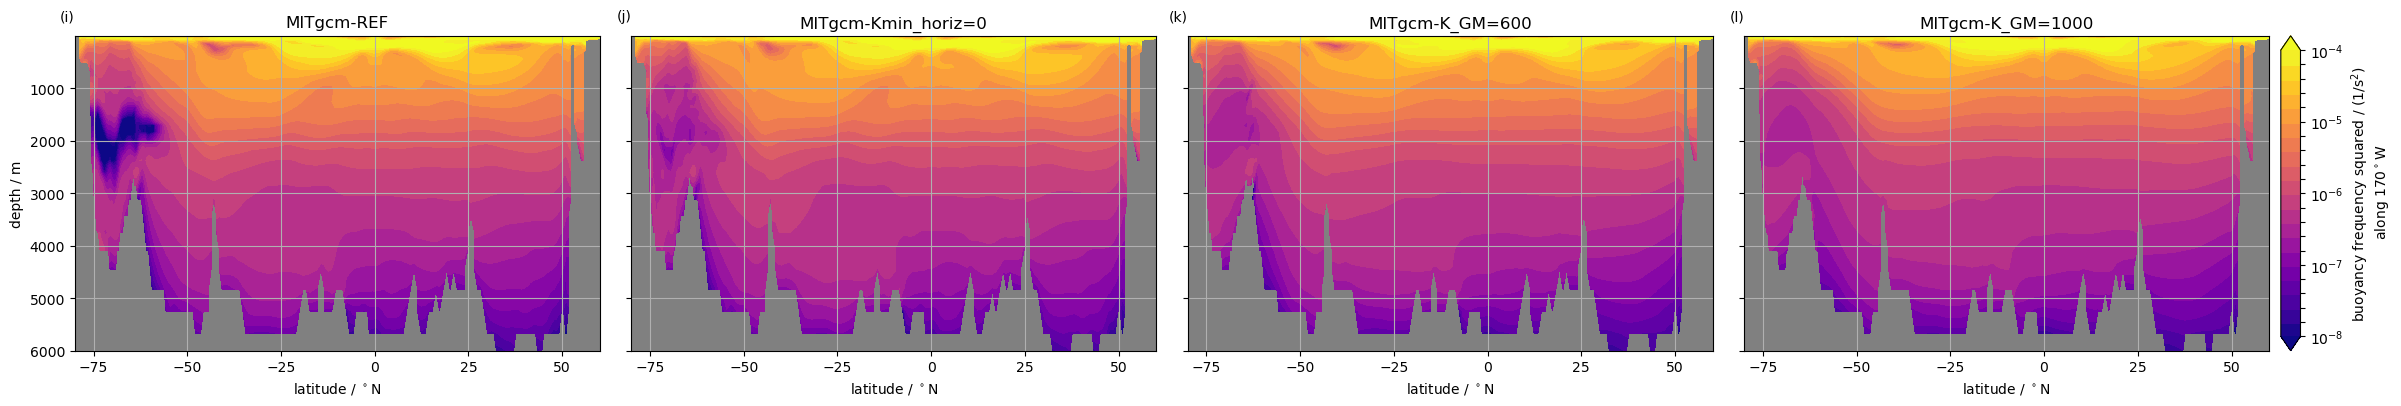

In [30]:
npx, npy = 4,1
hca, hcb = arrange_axes(npx, npy, plot_cb='right', asp=0.6, fig_size_fac=2,
                        sharex=True, sharey=True, xlabel='latitude / $^\circ$N', ylabel='depth / m',
                        do_axes_labels=False)
axlab(hca, figstr=figlabelstrs) 

clim, norm, contfs = get_log_clevs([-8, -4])

for ii,fname in enumerate(fnames):
    ax, cax = hca[ii],hcb[ii]
    cmap = plt.get_cmap('plasma')
    data_x, data_y, depth, data_v = section170(dsm[ii],-9.81/1035 * dsm[ii].DRHODR)
    data_y = dsm[ii].Zu.data
    # plotsec(ax, cax, data_x, data_y, data_v, contfs, fname)
    # hm=ax.contourf(data_x, -data_y, sq(data_v), levels=contfs, vmin=contfs[0], vmax=contfs[-1], 
    #               cmap=cmap, norm=norm, extend='both')
    #hm=ax.pcolormesh(data_x, -data_y, sq(data_v), cmap=cmap, norm=norm)
    #ax.contour(data_x, -data_y, sq(data_v), levels=contfs, colors = 'k', linewidths=0.5)
    hm=ax.contourf(data_x, -data_y, sq(data_v), levels=contfs, cmap=cmap, norm=norm, extend='both')
    #ax.fill_between(data_x,depth,6000,step='mid',facecolor=landcolor)
    #___________________________________________________________________________________
    # This is out of Niels pyicon.shade(...) routine
    if (cax!=0) and (hm is not None): 
        cbkwargs = dict(orientation='vertical', extend='both')
        cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=contfs, **cbkwargs)
        cb.solids.set_edgecolor("face")
        cb.set_ticks(contfs[contfs!=0.0])
        cb.ax.yaxis.set_major_formatter(mticker.LogFormatterSciNotation())

    #___________________________________________________________________________________  
    ax.set_title('MITgcm-%s'%fname)
    plot_settings(ax=ax, template='section',xlim=[-80,60])

cax.set_ylabel(f'buoyancy frequency squared / (1/s$^2$)\n along 170$^\circ$W')
if savefigs: put.savefig(os.path.join(fdir,'mitgcm_buoyfreq2_170w'))

### diffusivity

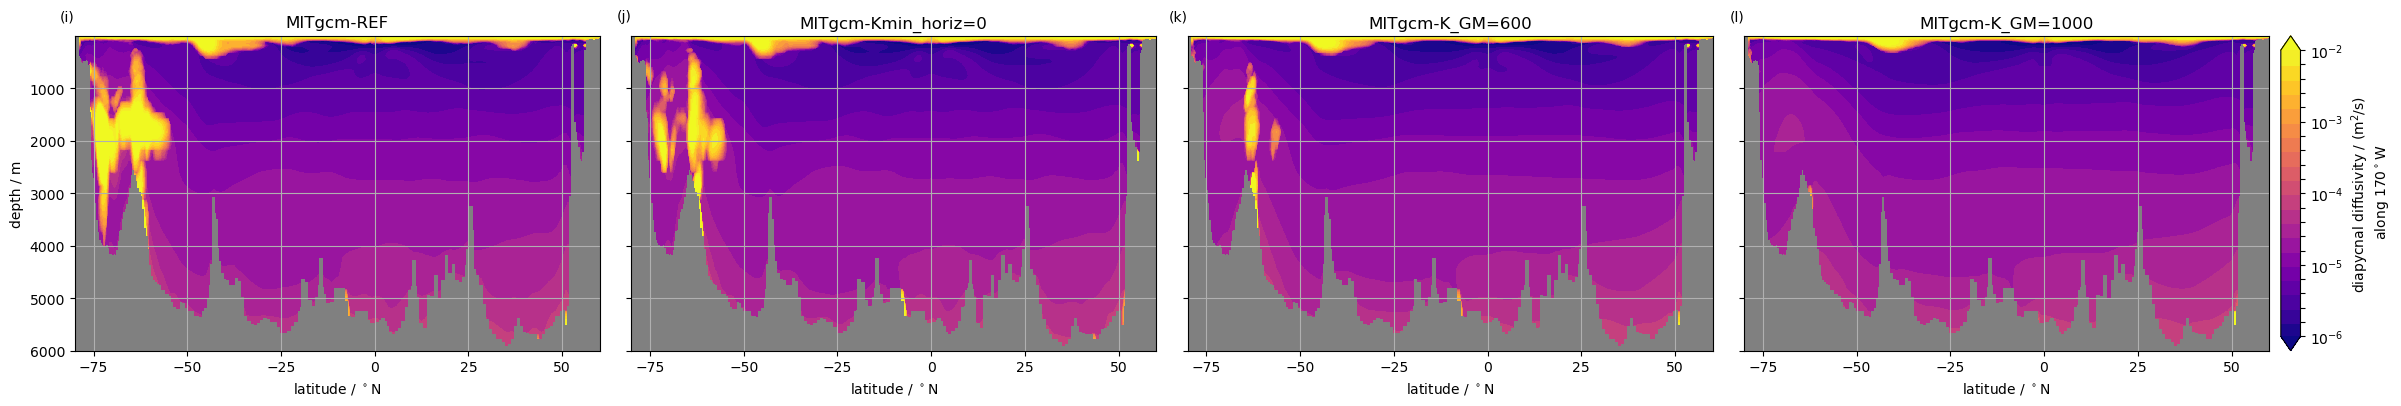

In [31]:
npx, npy = 4,1
hca, hcb = arrange_axes(npx, npy, plot_cb='right', asp=0.6, fig_size_fac=2, dfigr=1.0,
                        sharex=True, sharey=True, xlabel='latitude / $^\circ$N', ylabel='depth / m',
                        do_axes_labels=False)
axlab(hca, figstr=figlabelstrs)

clim, norm, contfs = get_log_clevs([-6, -2])

for ii,fname in enumerate(fnames):
    ax, cax = hca[ii],hcb[ii]
    cmap = plt.get_cmap('plasma')
    data_x, data_y, depth, data_v = section170(dsm[ii],dsm[ii].GGL90Kr)
    data_y = dsm[ii].Zu.data
    # plotsec(ax, cax, data_x, data_y, data_v, contfs, fname)
    hm=ax.contourf(data_x, -data_y, sq(data_v), levels=contfs, vmin=contfs[0], vmax=contfs[-1], 
                   cmap=cmap, norm=norm, extend='both')
    #hm=ax.pcolormesh(data_x, -data_y, sq(data_v), cmap=cmap, norm=norm)
    #ax.contour(data_x, -data_y, sq(data_v), levels=contfs, colors = 'k', linewidths=0.5)
    ax.fill_between(data_x,depth,6000,step='mid',facecolor=landcolor)
    #___________________________________________________________________________________
    # This is out of Niels pyicon.shade(...) routine
    if (cax!=0) and (hm is not None): 
        cbkwargs = dict(orientation='vertical', extend='both')
        cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=contfs, **cbkwargs)
        cb.solids.set_edgecolor("face")
        cb.set_ticks(contfs[contfs!=0.0])
        cb.ax.yaxis.set_major_formatter(mticker.LogFormatterSciNotation())

    #___________________________________________________________________________________  
    ax.set_title('MITgcm-%s'%fname)
    plot_settings(ax=ax, template='section',xlim=[-80,60])

cax.set_ylabel(f'diapycnal diffusivity / (m$^2$/s)\n along 170$^\circ$W')
if savefigs: put.savefig(os.path.join(fdir,'mitgcm_diffusivity_170w'))

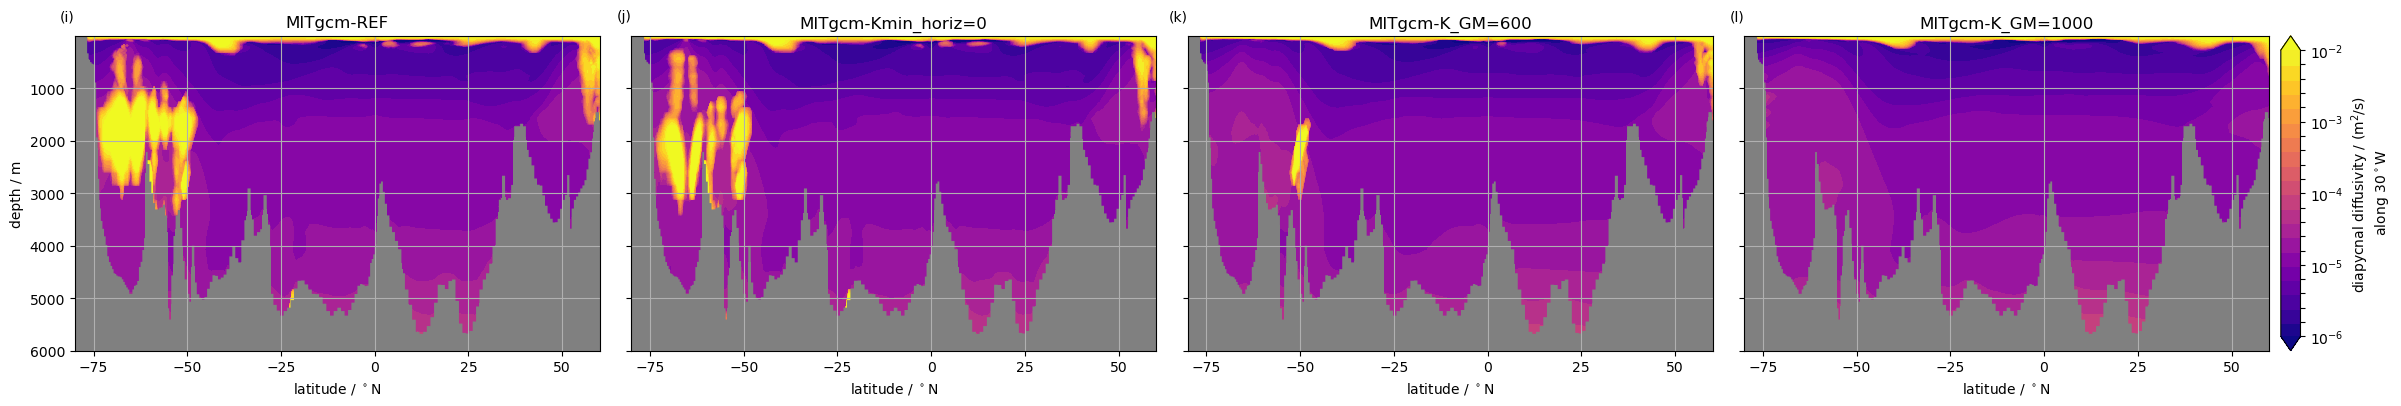

In [32]:
npx, npy = 4,1
hca, hcb = arrange_axes(npx, npy, plot_cb='right', asp=0.6, fig_size_fac=2,
                        sharex=True, sharey=True, xlabel='latitude / $^\circ$N', ylabel='depth / m',
                        do_axes_labels=False)
axlab(hca, figstr=figlabelstrs)

clim, norm, contfs = get_log_clevs([-6, -2])

for ii,fname in enumerate(fnames):
    ax, cax = hca[ii],hcb[ii]
    cmap = plt.get_cmap('plasma')
    data_x, data_y, depth, data_v = section30(dsm[ii],dsm[ii].GGL90Kr)
    data_y = dsm[ii].Zu.data
    hm=ax.contourf(data_x, -data_y, sq(data_v), levels=contfs, vmin=contfs[0], vmax=contfs[-1], 
                   cmap=cmap, norm=norm, extend='both')
    ax.fill_between(data_x,depth,6000,step='mid',facecolor=landcolor)
    #___________________________________________________________________________________
    # This is out of Niels pyicon.shade(...) routine
    if (cax!=0) and (hm is not None): 
        cbkwargs = dict(orientation='vertical', extend='both')
        cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=contfs, **cbkwargs)
        cb.solids.set_edgecolor("face")
        cb.set_ticks(contfs[contfs!=0.0])
        cb.ax.yaxis.set_major_formatter(mticker.LogFormatterSciNotation())

    #___________________________________________________________________________________  
    ax.set_title('MITgcm-%s'%fname)
    plot_settings(ax=ax, template='section',xlim=[-80,60])

cax.set_ylabel(f'diapycnal diffusivity / (m$^2$/s) \n along 30$^\circ$W')
if savefigs: put.savefig(os.path.join(fdir,'mitgcm_diffusivity_30w'))

### TKE production $\kappa N^2$

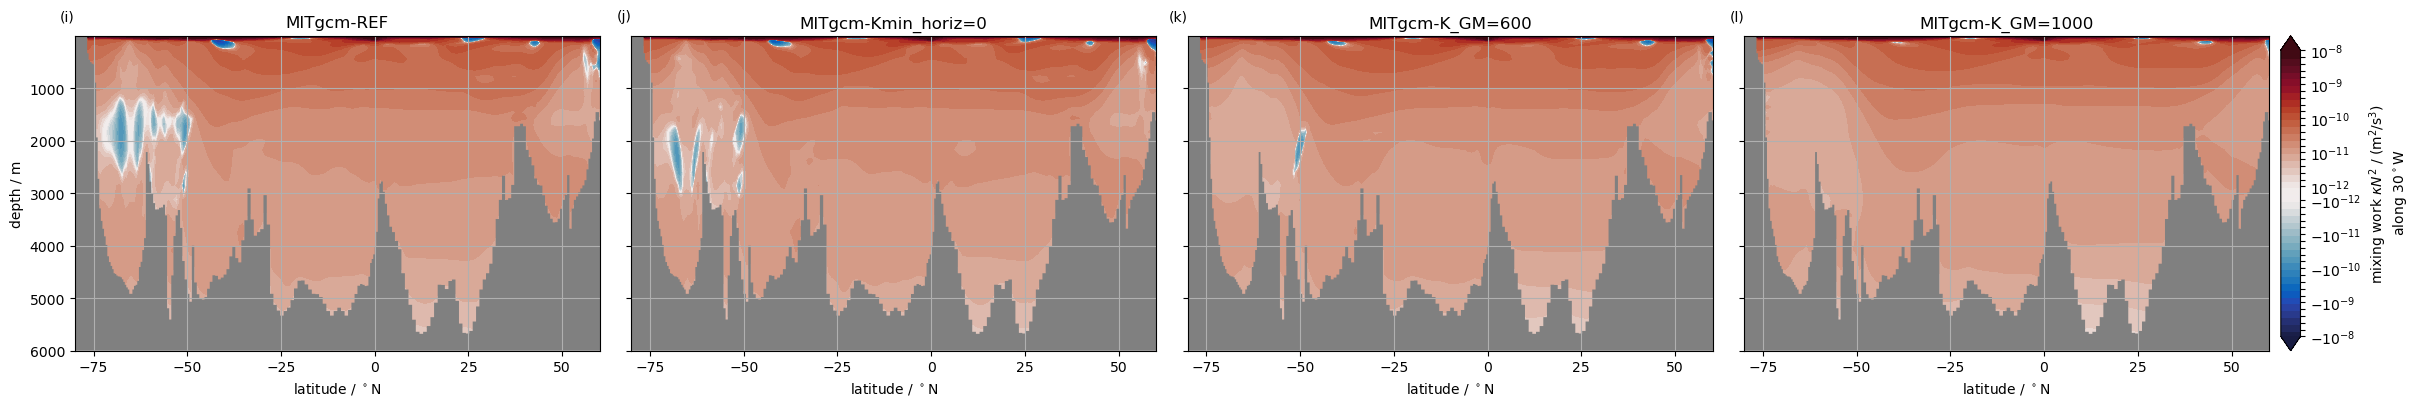

In [33]:
npx, npy = 4,1
hca, hcb = arrange_axes(npx, npy, plot_cb='right', asp=0.6, fig_size_fac=2, dfigr=1.0,
                        sharex=True, sharey=True, xlabel='latitude / $^\circ$N', ylabel='depth / m',
                        do_axes_labels=False)
axlab(hca, figstr=figlabelstrs)

clim, norm, contfs = get_log_clevs([-12,-8], dosym=True, numspaces=5)

for ii,fname in enumerate(fnames):
    ax, cax = hca[ii],hcb[ii]
    cmap = plt.get_cmap('plasma')
    data_x, data_y, depth, data_v = section30(dsm[ii],dsm[ii].GGL90KN2)
    data_y = dsm[ii].Zu.data
    hm=ax.contourf(data_x, -data_y, data_v, levels=contfs, vmin=contfs[0], vmax=contfs[-1], 
                   cmap=cmo.balance, norm=norm, extend='both')
    ax.fill_between(data_x,depth,6000,step='mid',facecolor=landcolor)
    #___________________________________________________________________________________
    # This is out of Niels pyicon.shade(...) routine
    if (cax!=0) and (hm is not None): 
        cbkwargs = dict(orientation='vertical', extend='both')
        cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=contfs, **cbkwargs)
        cb.solids.set_edgecolor("face")
        cb.set_ticks(contfs[contfs!=0.0])
        cb.ax.yaxis.set_major_formatter(mticker.LogFormatterSciNotation())
    #___________________________________________________________________________________  
    ax.set_title('MITgcm-%s'%fname)
    plot_settings(ax=ax, template='section',xlim=[-80,60])

cax.set_ylabel('mixing work $\kappa N^2$ / (m$^2$/s$^3$)\n along 30$^\circ$W')
if savefigs: put.savefig(os.path.join(fdir,'mitgcm_buoyancy_production_30w'))

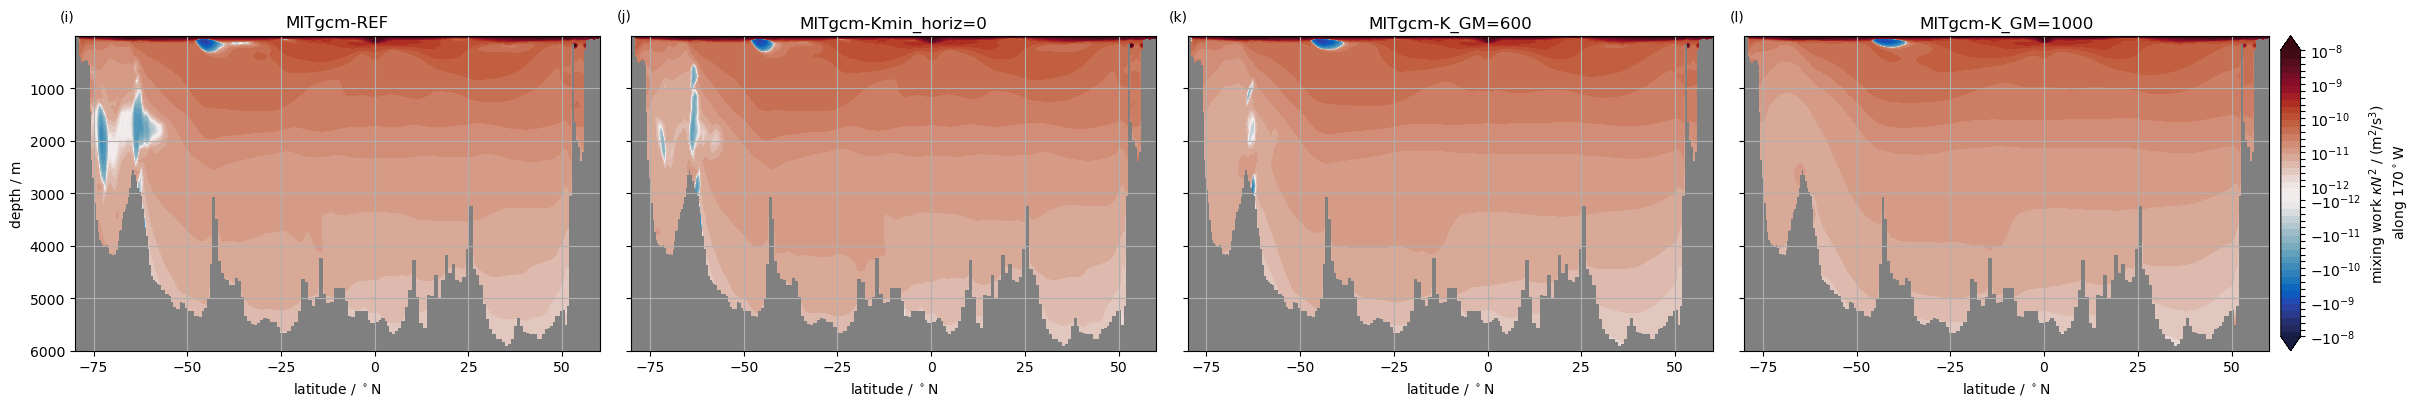

In [34]:
npx, npy = 4,1
hca, hcb = arrange_axes(npx, npy, plot_cb='right', asp=0.6, fig_size_fac=2, dfigr=1.0,
                        sharex=True, sharey=True, xlabel='latitude / $^\circ$N', ylabel='depth / m',
                        do_axes_labels=False)
axlab(hca, figstr=figlabelstrs)

clim, norm, contfs = get_log_clevs([-12,-8], dosym=True, numspaces=5)

for ii,fname in enumerate(fnames):
    ax, cax = hca[ii],hcb[ii]
    cmap = plt.get_cmap('plasma')
    data_x, data_y, depth, data_v = section170(dsm[ii],dsm[ii].GGL90KN2)
    data_y = dsm[ii].Zu.data
    hm=ax.contourf(data_x, -data_y, data_v, levels=contfs, vmin=contfs[0], vmax=contfs[-1], 
                   cmap=cmo.balance, norm=norm, extend='both')
    ax.fill_between(data_x,depth,6000,step='mid',facecolor=landcolor)
    #___________________________________________________________________________________
    # This is out of Niels pyicon.shade(...) routine
    if (cax!=0) and (hm is not None): 
        cbkwargs = dict(orientation='vertical', extend='both')
        cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=contfs, **cbkwargs)
        cb.solids.set_edgecolor("face")
        cb.set_ticks(contfs[contfs!=0.0])
        cb.ax.yaxis.set_major_formatter(mticker.LogFormatterSciNotation())
    #___________________________________________________________________________________  
    ax.set_title('MITgcm-%s'%fname)
    plot_settings(ax=ax, template='section',xlim=[-80,60])

cax.set_ylabel('mixing work $\kappa N^2$ / (m$^2$/s$^3$)\n along 170$^\circ$W')
if savefigs: put.savefig(os.path.join(fdir,'mitgcm_buoyancy_production_170w'))

### diagnostics of energy production in TKE run

In [35]:
# multiply by constant density to get energy/volume 
# and divide by timestep to convert to a rate (should have been done in the code)
rho_const = 1035/3600
totenergy = 0
totvolume = 0
for k in range(1,dsm[0].GGL90Emn.shape[0]):
    dvol = coords.drC[k]*coords.rA*coords.hFacC[k,...]*coords.hFacC[k-1,...]
    totvolume = totvolume + (dvol).sum()
    totenergy = totenergy + (dvol*dsm[0].GGL90Emn[k,...]).sum()
    #print(k,dvol.sum().values,totvolume.values,totenergy.values)

print('total energy generated by TKE cutoff = %e TW'%((rho_const*totenergy*1e-12).values))
print('mean  energy generated by TKE cutoff = %e W/m^3'%((rho_const*totenergy/totvolume).values))

total energy generated by TKE cutoff = 2.485080e-01 TW
mean  energy generated by TKE cutoff = 1.943740e-07 W/m^3


## hydrography biases

In [36]:
f = open('/albedo/home/mlosch/idemix_forcing/temp_annual_phc3.0.llc90.bin','r')
tphc = mdsTo13faces(np.fromfile(f,'>f4').reshape((50,1170,90)))
f.close()

f = open('/albedo/home/mlosch/idemix_forcing/salt_annual_phc3.0.llc90.bin','r')
sphc = mdsTo13faces(np.fromfile(f,'>f4').reshape((50,1170,90)))
f.close()

global_mask, atlantic_mask, indopacific_mask = make_masks(coords,withoutArctic=False)

msk3d = coords.hFacC
#msk3d = msk3d.where(msk3d>0,1,0)
global_mask = msk3d*global_mask
atlantic_mask = msk3d*atlantic_mask
indopacific_mask = msk3d*indopacific_mask

llcinterp2d = LLCinterp(coords, dx=0.25, dy=0.25)
#llcinterp2d = LLCinterp(coords, dx=1., dy=1.)

tlevs = np.linspace(-2,2,21)
slevs = np.linspace(-.4,.4,21)
tcbkwargs = dict(orientation='vertical', extend='both', label=r'temperature anomaly / $\circ$C')
scbkwargs = dict(orientation='vertical', extend='both', label=r'salinity anomatly')

class LLCinterp:

    def __init__(self, ds, dx=0.25, dy=0.25):
        # Extract LLC 2D coordinates
        lons_1d = ds.XC.values.ravel()
        lats_1d = ds.YC.values.ravel()

        # Define original grid
        self.orig_grid = pyresample.geometry.SwathDefinition(
            lons=lons_1d, lats=lats_1d)

        # Longitudes latitudes to which we will we interpolate
        lon_tmp = np.arange(-180, 180, dx) + dx/2
        lat_tmp = np.arange(-90, 90, dy) + dy/2

        # Define the lat lon points of the two parts.
        self.new_grid_lon, self.new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
        self.new_grid  = pyresample.geometry.GridDefinition(
            lons=self.new_grid_lon, lats=self.new_grid_lat)

    def __call__(self, da):

        assert set(da.dims) == set(
            ['face', 'j', 'i']), "da must have dimensions ['face', 'j', 'i']"


        # field = pyresample.kd_tree.resample_gauss(self.orig_grid, da.values,
        #                                           self.new_grid,
        #                                           radius_of_influence=100e3, 
        #                                           sigmas = 25e3)

        field = pyresample.kd_tree.resample_nearest(self.orig_grid, da.values,
                                                    self.new_grid,
                                                    radius_of_influence=100e3,
                                                    fill_value=None)
        return field

def plotzonalbias(ax,ds,dfield,levs,msk=1.,tstr='dummy',cmap=None):

    lon = llcinterp2d.new_grid_lon
    lat = llcinterp2d.new_grid_lat

    d = llcinterp2d(ds.Depth*msk[0,...]).max(axis=-1)
    y = lat[:,0]
    z = ds.Z
    
    nz = dfield.shape[0]
    #dfld=interp3dFld(dfield,msk)
    #dfld = np.ma.masked_array(dfld,dfld==0.)
    #dfldx = dfld.mean(axis=-1)
    #ylat = y
    ylat, dfldx = zonave(dfield, ds.YC, msk=msk, res=1)
        
    print('done with interpolation')

    
    csf=ax.contourf(ylat,-z,dfldx,levels=levs,extend='both',cmap=cmap)
    #ax.contour(ylat,z,dfldx,levels=levs,colors='gray',linewidths=0.25)
    ax.fill_between(y,d,ds.drF.sum(),step='mid',facecolor=landcolor)
    ax.set_title('%s'%(tstr))
    ax.grid()
    return csf

def zonave(data, clat, msk, res=0.3):
    # based on Nils zonave
    lat_group = np.round(clat/res)*res
    # data_zave = data.where(msk>0.).groupby(lat_group).mean()
    data_sum = (data*msk).where(msk>0.).groupby(lat_group).sum()
    vol_sum = msk.where(msk>0.).groupby(lat_group).sum()
    data_zave = data_sum/vol_sum.where(vol_sum>0.)
    latg = np.unique(lat_group.values.ravel())
    lat = latg - 0.5*res
    return lat, data_zave

def interp3dFld(dfield,msk=1.):

    nny,nnx=llcinterp2d.new_grid_lat.shape
    nz = dfield.shape[0]
    dfld=np.zeros((nz,nny,nnx))
    for k in range(nz):
        #print('level %i'%k)
        dfld[k,...] = llcinterp2d(dfield[k,...]*msk)
        
    return dfld


### global

done with interpolation
done with interpolation
done with interpolation
done with interpolation


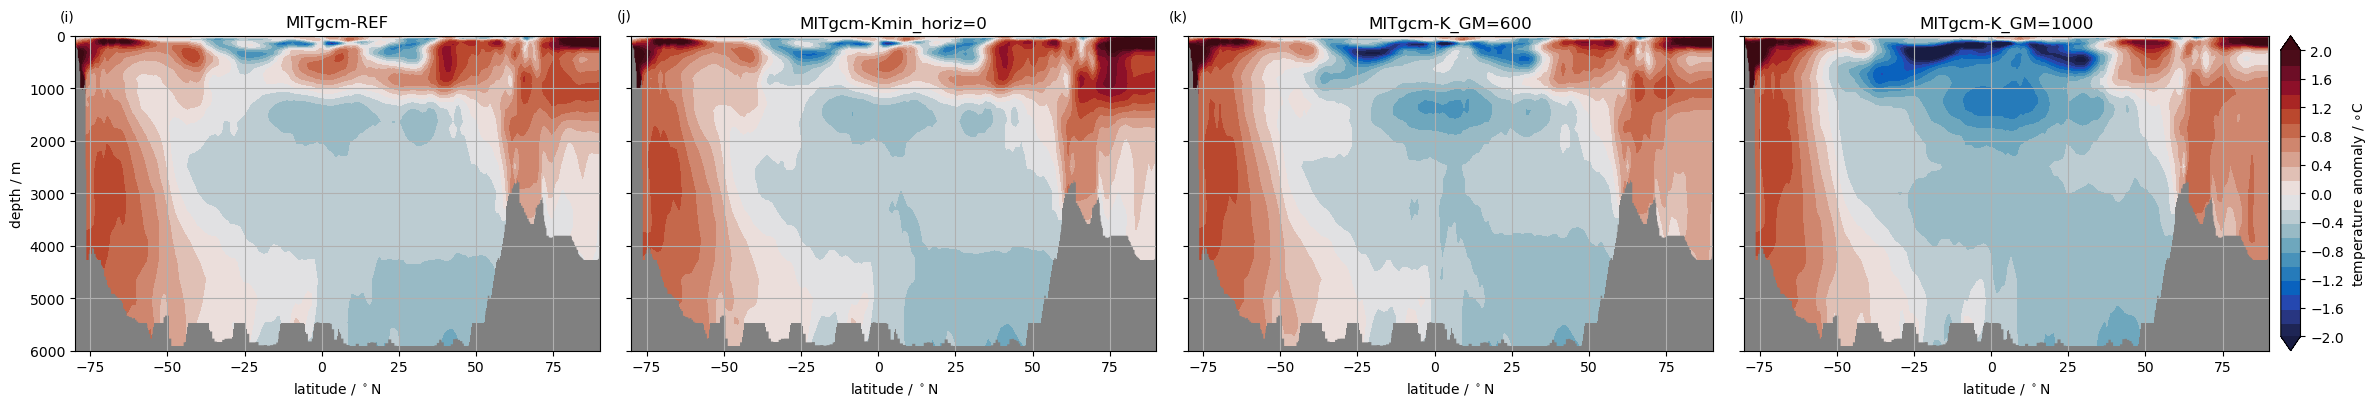

In [37]:
npx,npy=4,1

hca, hcb = arrange_axes(npx, npy, plot_cb='right', asp=0.6, fig_size_fac=2,
                        sharex=True, sharey=True, xlabel='latitude / $^\circ$N', ylabel='depth / m',
                        do_axes_labels=False)
axlab(hca, figstr=figlabelstrs)

#for k in range(len(dsm)):
for k in range(len(fnames)):
    ax, cax = hca[k],hcb[k]
    hm = plotzonalbias(ax,dsm[k],dsm[k].THETA-tphc, tlevs, global_mask,'MITgcm-%s'%fnames[k],cmap=cmo.balance)
    if (cax!=0) and (hm is not None): 
        cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=tlevs[::-2], **tcbkwargs)
        cb.solids.set_edgecolor("face")

for ax in hca:
    ax.set_xticks(np.arange(-75,90,25))
    ax.set_xlim(-80,90)
    ax.set_ylim([6000,0])
    ax.set_facecolor(landcolor)

if savefigs: put.savefig(os.path.join(fdir,'mitgcm_temp_bias_gzave.png'),dpi=300)

done with interpolation
done with interpolation
done with interpolation
done with interpolation


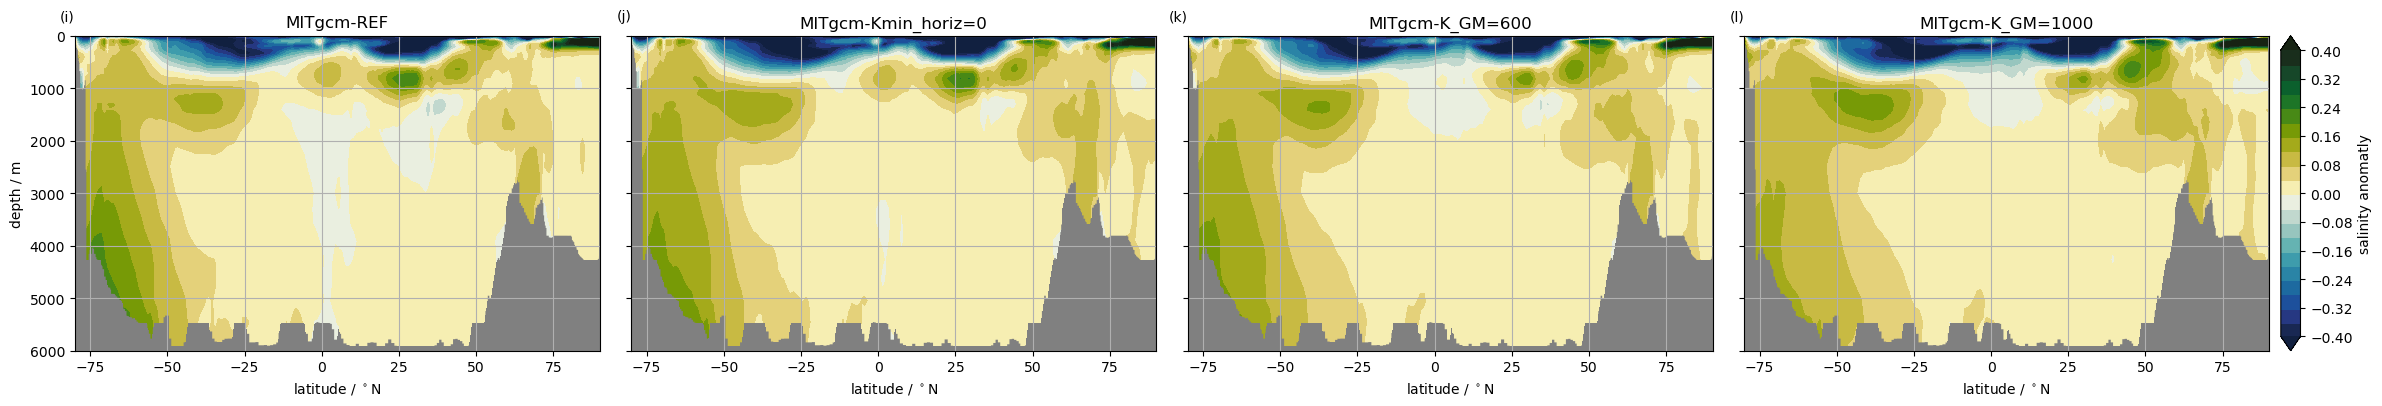

In [38]:
npx,npy=4,1

hca, hcb = arrange_axes(npx, npy, plot_cb='right', asp=0.6, fig_size_fac=2,
                        sharex=True, sharey=True, xlabel='latitude / $^\circ$N', ylabel='depth / m',
                        do_axes_labels=False)
axlab(hca, figstr=figlabelstrs)

#for k in range(len(dsm)):
for k in range(len(fnames)):
    ax, cax = hca[k],hcb[k]
    hm = plotzonalbias(ax,dsm[k],dsm[k].SALT-sphc, slevs, global_mask,'MITgcm-%s'%fnames[k],cmap=cmo.delta)
    if (cax!=0) and (hm is not None): 
        cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=slevs[::-2], **scbkwargs)
        cb.solids.set_edgecolor("face")

for ax in hca:
    ax.set_xticks(np.arange(-75,90,25))
    ax.set_xlim([-80,90])
    ax.set_ylim([6000,0])
    ax.set_facecolor(landcolor)

if savefigs: put.savefig(os.path.join(fdir,'mitgcm_salt_bias_gzave.png'),dpi=300)

### atlantic

done with interpolation
done with interpolation
done with interpolation
done with interpolation


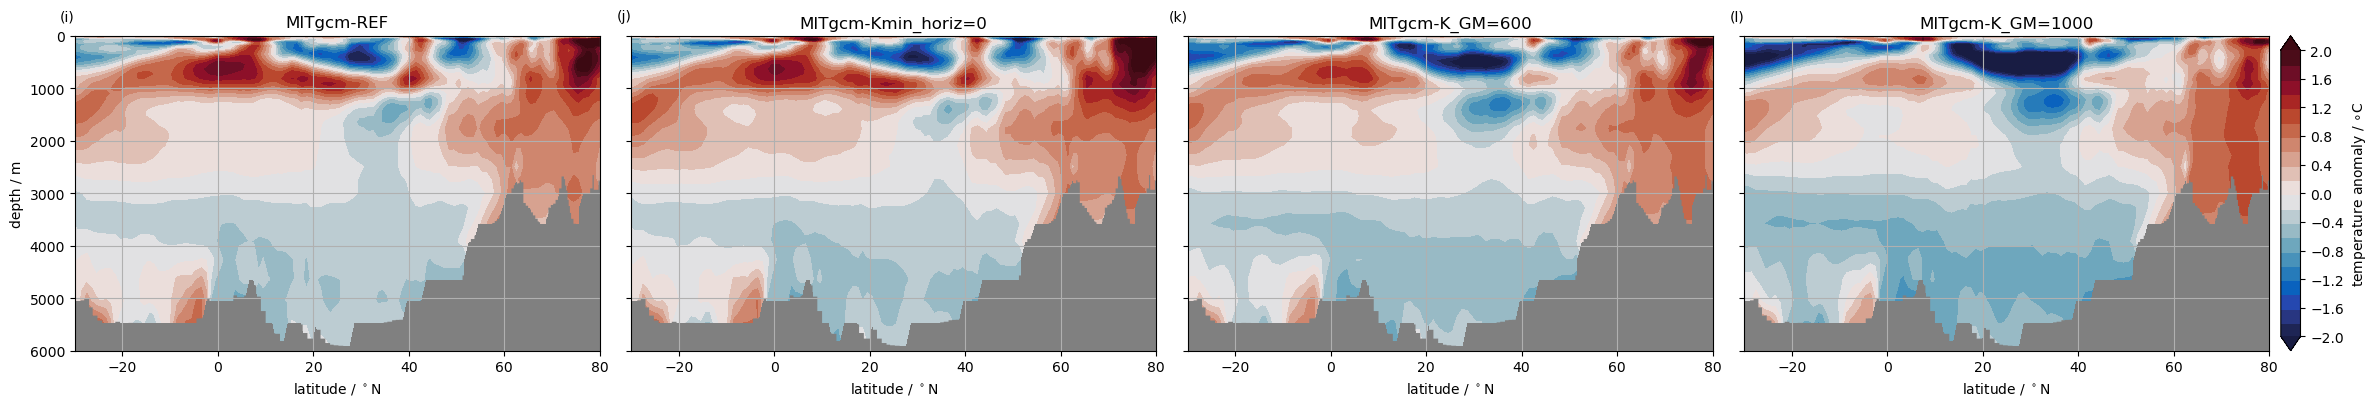

In [39]:
npx,npy=4,1

hca, hcb = arrange_axes(npx, npy, plot_cb='right', asp=0.6, fig_size_fac=2,
                        sharex=True, sharey=True, xlabel='latitude / $^\circ$N', ylabel='depth / m',
                        do_axes_labels=False)
axlab(hca, figstr=figlabelstrs)

#for k in range(len(dsm)):
for k in range(len(fnames)):
    ax, cax = hca[k],hcb[k]
    hm = plotzonalbias(ax,dsm[k],dsm[k].THETA-tphc, tlevs, atlantic_mask,'MITgcm-%s'%fnames[k],cmap=cmo.balance)
    if (cax!=0) and (hm is not None): 
        cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=tlevs[::-2], **tcbkwargs)
        cb.solids.set_edgecolor("face")

for ax in hca:
    ax.set_xticks(np.arange(-20,90,20))
    ax.set_xlim([-30,80])
    ax.set_ylim([6000,0])
    ax.set_facecolor(landcolor)

if savefigs: put.savefig(os.path.join(fdir,'mitgcm_temp_bias_azave.png'),dpi=300)

done with interpolation
done with interpolation
done with interpolation
done with interpolation


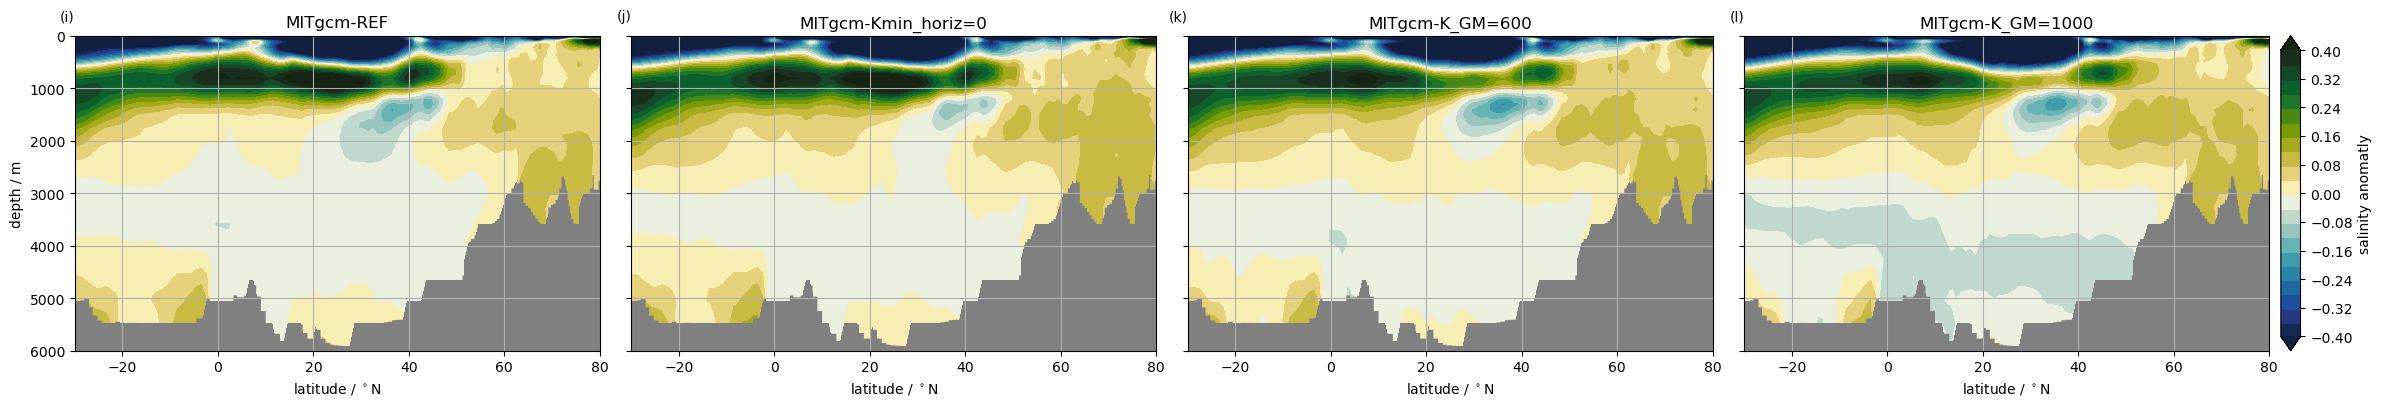

In [40]:
npx,npy=4,1

hca, hcb = arrange_axes(npx, npy, plot_cb='right', asp=0.6, fig_size_fac=2,
                        sharex=True, sharey=True, xlabel='latitude / $^\circ$N', ylabel='depth / m',
                        do_axes_labels=False)
axlab(hca, figstr=figlabelstrs)

#for k in range(len(dsm)):
for k in range(len(fnames)):
    ax, cax = hca[k],hcb[k]
    hm = plotzonalbias(ax,dsm[k],dsm[k].SALT-sphc, slevs, atlantic_mask,'MITgcm-%s'%fnames[k],cmap=cmo.delta)
    if (cax!=0) and (hm is not None): 
        cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=slevs[::-2], **scbkwargs)
        cb.solids.set_edgecolor("face")

for ax in hca:
    ax.set_xticks(np.arange(-20,90,20))
    ax.set_xlim([-30,80])
    ax.set_ylim([6000,0])
    ax.set_facecolor(landcolor)

if savefigs: put.savefig(os.path.join(fdir,'mitgcm_salt_bias_azave.png'),dpi=300)

### indo-pacific

done with interpolation
done with interpolation
done with interpolation
done with interpolation


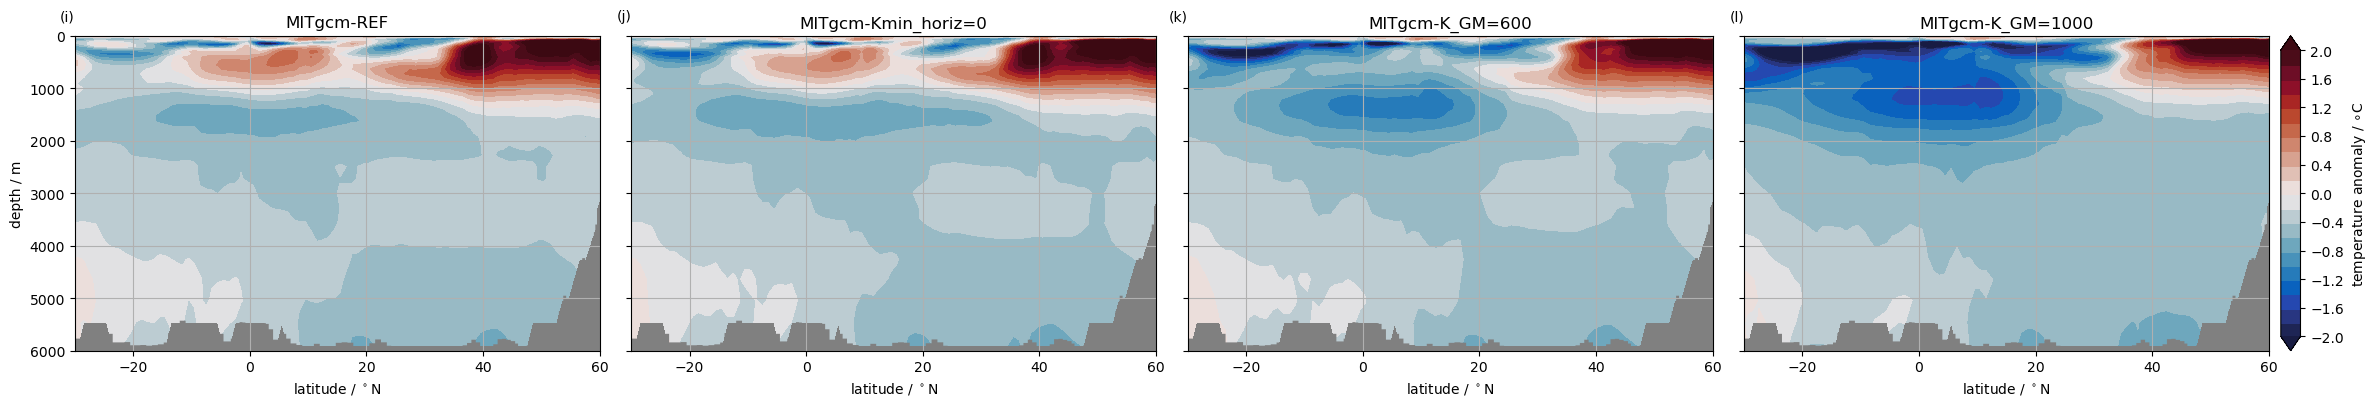

In [41]:
npx,npy=4,1

hca, hcb = arrange_axes(npx, npy, plot_cb='right', asp=0.6, fig_size_fac=2,
                        sharex=True, sharey=True, xlabel='latitude / $^\circ$N', ylabel='depth / m',
                        do_axes_labels=False)
axlab(hca, figstr=figlabelstrs)

#for k in range(len(dsm)):
for k in range(len(fnames)):
    ax, cax = hca[k],hcb[k]
    hm = plotzonalbias(ax,dsm[k],dsm[k].THETA-tphc, tlevs, indopacific_mask,'MITgcm-%s'%fnames[k],cmap=cmo.balance)
    if (cax!=0) and (hm is not None): 
        cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=tlevs[::-2], **tcbkwargs)
        cb.solids.set_edgecolor("face")

for ax in hca:
    ax.set_xticks(np.arange(-20,90,20))
    ax.set_xlim([-30,60])
    ax.set_ylim([6000,0])
    ax.set_facecolor(landcolor)

if savefigs: put.savefig(os.path.join(fdir,'mitgcm_temp_bias_ipzave.png'),dpi=300)

done with interpolation
done with interpolation
done with interpolation
done with interpolation


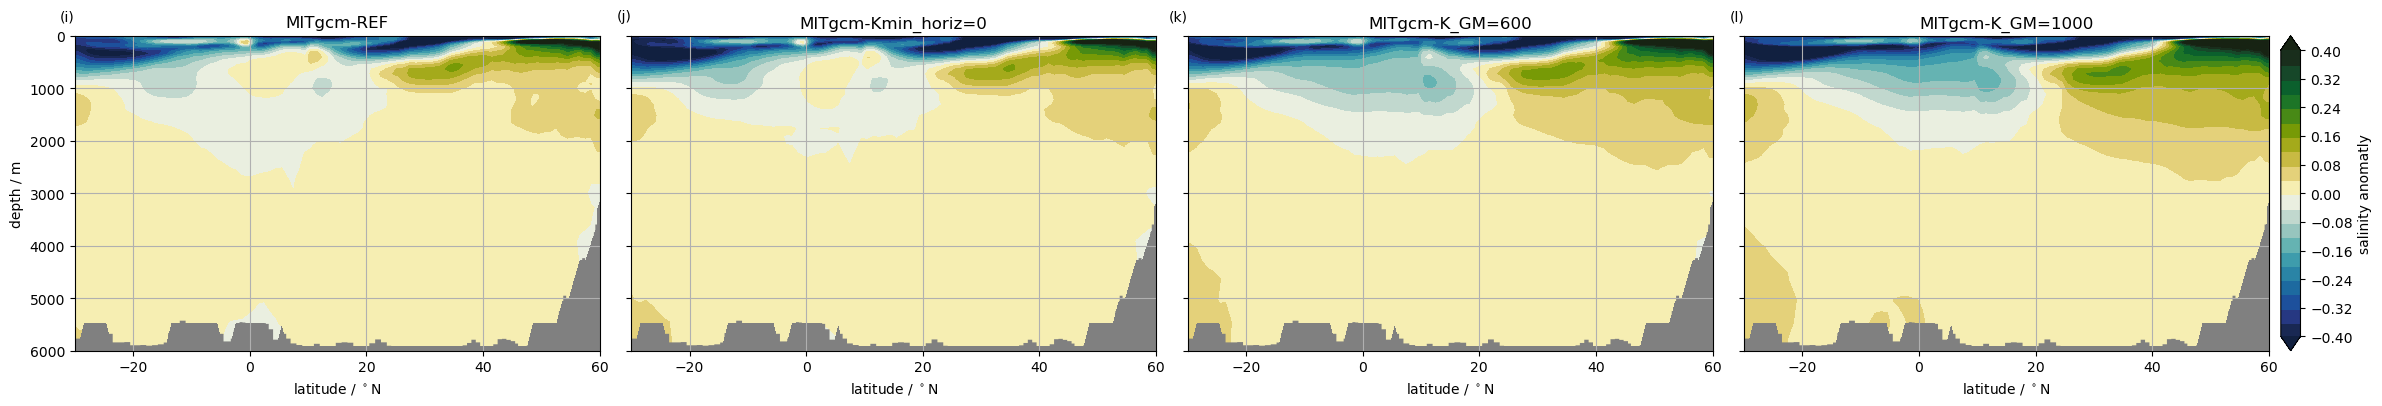

In [42]:
npx,npy=4,1

hca, hcb = arrange_axes(npx, npy, plot_cb='right', asp=0.6, fig_size_fac=2,
                        sharex=True, sharey=True, xlabel='latitude / $^\circ$N', ylabel='depth / m',
                        do_axes_labels=False)
axlab(hca, figstr=figlabelstrs)

#for k in range(len(dsm)):
for k in range(len(fnames)):
    ax, cax = hca[k],hcb[k]
    hm = plotzonalbias(ax,dsm[k],dsm[k].SALT-sphc, slevs, indopacific_mask,'MITgcm-%s'%fnames[k],cmap=cmo.delta)
    if (cax!=0) and (hm is not None): 
        cb = plt.colorbar(mappable=hm, ax=ax, cax=cax, ticks=slevs[::-2], **scbkwargs)
        cb.solids.set_edgecolor("face")

for ax in hca:
    ax.set_xticks(np.arange(-20,90,20))
    ax.set_xlim([-30,60])
    ax.set_ylim([6000,0])
    ax.set_facecolor(landcolor)

if savefigs: put.savefig(os.path.join(fdir,'mitgcm_salt_bias_ipzave.png'),dpi=300)

## 5 deg bins

In [43]:
bins = np.linspace(-90,90,37)
ds=dsm[0]
dz = np.where(ds.Zp1<=-1000,ds.drC,0)[:-1]
# partial cells require this (only relevant near the bottom):
hFacI = np.minimum(ds.hFacC,0.5)+np.roll(np.minimum(ds.hFacC,0.5),1,axis=0) # this is OK as we do not need index 0 (which will be wrong)
dvol = (dz.reshape((50,1,1,1))*hFacI*ds.rA).values
kN2 = []
kN2mean = []
for ds in dsm:
    kN2loc = []
    kN2meanLoc = []
    for k,bin in enumerate(bins[:-1]):
        mskBin = np.logical_and(np.logical_and(grid.YG>=bins[k],grid.YG<bins[k+1]),np.logical_and(grid.XG>-171,grid.XG<-169)).values
        fld=(dvol*ds.GGL90KN2*mskBin)
        vol=(dvol*mskBin).sum()
        kN2loc.append(fld.sum().values)
        if vol>0:
            kN2meanLoc.append(kN2loc[-1]/vol)
        else:
            kN2meanLoc.append(0)        
#        print(bins[k],bins[k+1],fld.sum().values)

    kN2.append(kN2loc)
    kN2mean.append(kN2meanLoc)
 

[7.4121928e-08 7.5982115e-08 7.3896217e-08 7.0761189e-08]


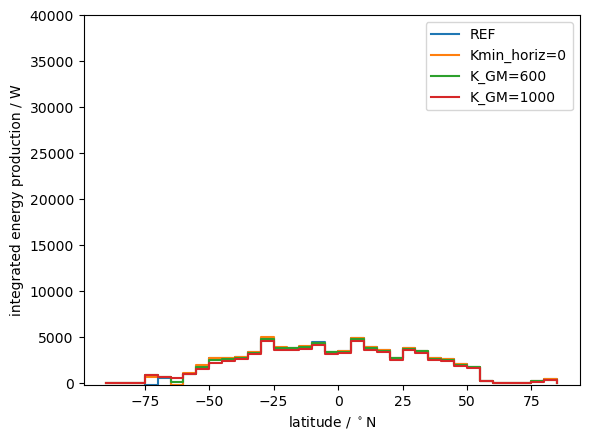

In [44]:
fig, ax = plt.subplots(1,1)
for k in range(len(kN2)):
#    hm=ax.bar(bins[:-1],np.asarray(kN2[k])*1e-12,align='edge',width=5,edgecolor='k',alpha=0.2,label=fnames[k])
    hm=ax.step(bins[:-1],np.asarray(kN2[k]),where='post',label=fnames[k])
    
ax.set_ylim((-200,40000))
ax.set_ylabel('integrated energy production / W')
ax.set_xlabel(r'latitude / $^\circ$N')
ax.legend()
#dvol.sum()
print(np.asarray(kN2).sum(axis=-1)*1e-12)

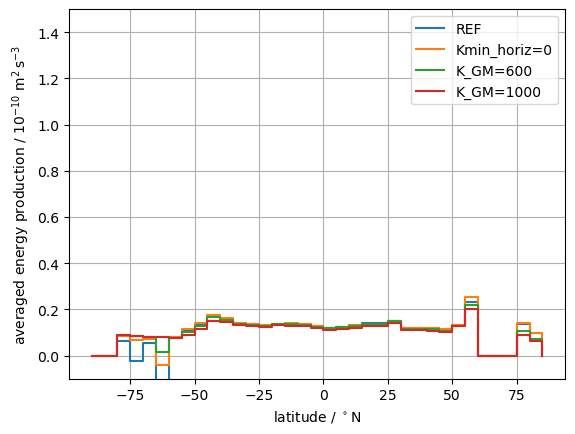

In [45]:
fig, ax = plt.subplots(1,1)
for k in range(len(kN2)):
    hm=ax.step(bins[:-1],np.asarray(kN2mean[k])*1e10,where='post',label=fnames[k])
    
ax.set_ylim((-.1,1.5))
ax.set_ylabel(r'averaged energy production / $10^{-10}\ $m$^2\,$s$^{-3}$')
ax.set_xlabel(r'latitude / $^\circ$N')
ax.legend()
ax.grid()

### save data

In [46]:
ds = xr.Dataset()
y = 0.5*(bins[:-1]+bins[1:])
for r,fname in enumerate(fnames):
    # dg = xr.DataArray(kN2, dims=("lat"), coords={"lat": y, "long_name": "center of latitude bins", "units": "degN"},
    #                   attrs={"name": "integrated energy production", "units": "PW", "_fillValue": 0., "run": "MITgcm-%s"%fname})
    da = xr.DataArray(kN2mean[r], dims=("latc"), coords={"latc": ("latc", y, {"long_name": "center of latitude bins", "units": "degN"})},
                      attrs={"name": "mean energy production", "units": "m^2 s^{-3}", 
                             "_FillValue": kN2mean[r][0], "run": "MITgcm-%s"%fname})
    ds["kN2m_%s"%(fname)] = da

#ds.assign_coords({"latg": ("latg", bins)}) # "attrs", {"long_name": "corners of latitude bins", "units": "degN"})
#ds.to_netcdf(os.path.join(postprocdir,'%s_binned_energy_production.nc'%ctrlrun))
ds

<xarray.Dataset>
Dimensions:            (latc: 36)
Coordinates:
  * latc               (latc) float64 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
Data variables:
    kN2m_REF           (latc) float64 0.0 0.0 6.257e-12 ... 9.791e-12 0.0
    kN2m_Kmin_horiz=0  (latc) float64 0.0 0.0 8.471e-12 ... 9.902e-12 0.0
    kN2m_K_GM=600      (latc) float64 0.0 0.0 8.975e-12 ... 7.191e-12 0.0
    kN2m_K_GM=1000     (latc) float64 0.0 0.0 8.832e-12 ... 6.286e-12 0.0

In [47]:
kN2mean[r][0]

0

# heat transports

## plots 

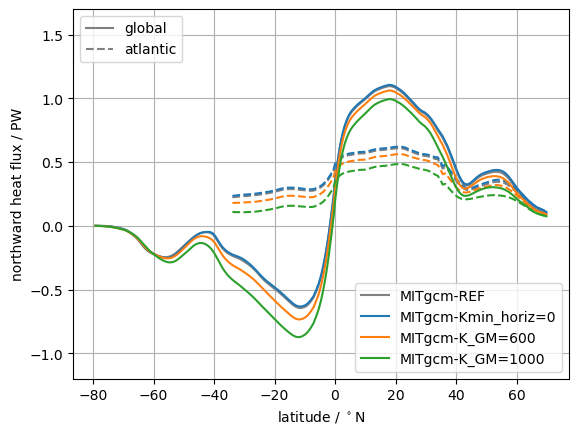

In [48]:
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)

def merdional_heatflux(ds,msk):
    mskW = grd.interp(msk,axis='X',to='left',boundary='fill')
    mskS = grd.interp(msk,axis='Y',to='left',boundary='fill')
    mskW=mskW.where(mskW==1)
    mskS=mskS.where(mskS==1)
    txflx = (ds.ADVx_TH + ds.DFxE_TH).sum(dim='k')
    tyflx = (ds.ADVy_TH + ds.DFyE_TH).sum(dim='k')
    trsp_x = (txflx*mskW.values).sum(dim=['j'])*10**-15 * 1000 * 4000
    trsp_y = (tyflx*mskS.values).sum(dim=['i'])*10**-15 * 1000 * 4000
    ty = np.concatenate((trsp_y[0:3 ,:].values+trsp_y[ 3:6 ,:].values), axis=0)
    tx = np.concatenate((trsp_x[7:10,:].values+trsp_x[10:13,:].values), axis=0)[::-1]
    hf = np.zeros(ty.shape)
    hf[1:]=-tx[:-1]+ty[1:]
    return hf

msks = [global_mask,atlantic_mask]
labs = ['global', 'atlantic']
lstl = ['-','--']
colors = ['k','r','b','g']
colors = ['gray','#1f77b4','#ff7f0e','#2ca02c','#d62728'] 
fig,ax = plt.subplots(1,1)
y = np.hstack((coords.YG.isel(face=slice(0,3)).mean(dim='i_g')))
lines = []
for r,fname in enumerate(fnames):

    ds = dshf[r]
    # txflx = (ds.ADVx_TH + ds.DFxE_TH).sum(dim='k')
    # tyflx = (ds.ADVy_TH + ds.DFyE_TH).sum(dim='k')

    for k, msk in enumerate(msks):
        hf = merdional_heatflux(dshf[r],msk)
        ax.plot(y,sq(hf),color=colors[r],linestyle=lstl[k],label="MITgcm-%s"%fname) #,alpha=0.5)

ax.grid()
first_legend=ax.legend(['global','atlantic'],loc='upper left')
bx = ax.add_artist(first_legend)
handles=ax.get_legend_handles_labels()
#print(handles)
ax.legend(handles=(handles[0][::2]),loc='lower right')
ax.set_ylim([-1.2,1.7])
ax.set_xlabel('latitude / $^\circ$N')
ax.set_ylabel('northward heat flux / PW')
if savefigs: put.savefig(os.path.join(fdir,'mitgcm_heatflux.png'),dpi=300)

## save data

In [49]:
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)
y = np.hstack((coords.YG.isel(face=slice(0,3)).mean(dim='i_g')))
r = 0
ds = xr.Dataset()
for r,fname in enumerate(fnames):
    ghf = (merdional_heatflux(dshf[r],global_mask))
    ahf = (merdional_heatflux(dshf[r],atlantic_mask))
    dg = xr.DataArray(ghf, dims=("lat"), coords={"lat": ("lat", y, {"units": "degN"})},
                      attrs={"name": "global heat flux", "units": "PW", "_FillValue": 0., "run": "MITgcm-%s"%fname})
    da = xr.DataArray(ahf, dims=("lat"), coords={"lat": ("lat", y, {"units": "degN"})}, 
                      attrs={"name": "atlantic heat flux", "units": "PW", "_FillValue": 0., "run": "MITgcm-%s"%fname})
    ds["ahf_%s"%(fname)] = da
    ds["ghf_%s"%(fname)] = dg

#ds.to_netcdf(os.path.join(postprocdir,'%s_heat_fluxes.nc'%ctrlrun))
ds

<xarray.Dataset>
Dimensions:           (lat: 270)
Coordinates:
  * lat               (lat) float64 -85.46 -85.45 -85.41 ... 69.21 69.56 69.91
Data variables:
    ahf_REF           (lat) float64 0.0 0.0 0.0 0.0 ... 0.1069 0.09521 0.08414
    ghf_REF           (lat) float64 0.0 0.0 0.0 0.0 ... 0.1079 0.1032 0.09862
    ahf_Kmin_horiz=0  (lat) float64 0.0 0.0 0.0 0.0 ... 0.1171 0.1044 0.09264
    ghf_Kmin_horiz=0  (lat) float64 0.0 0.0 0.0 0.0 ... 0.1181 0.1129 0.1077
    ahf_K_GM=600      (lat) float64 0.0 0.0 0.0 0.0 ... 0.09474 0.08411 0.07415
    ghf_K_GM=600      (lat) float64 0.0 0.0 0.0 0.0 ... 0.09565 0.09173 0.08795
    ahf_K_GM=1000     (lat) float64 0.0 0.0 0.0 0.0 ... 0.07922 0.06947 0.06031
    ghf_K_GM=1000     (lat) float64 0.0 0.0 0.0 0.0 ... 0.08013 0.0771 0.0741